In [122]:
# Imports
from ypstruct import structure
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from scipy.spatial.distance import pdist, squareform
import re
import pandas as pd
import seaborn as sns

In [123]:
def read_TTP_instance_data(file_path: str) -> dict:

    """
    Read TTP (Travelling Thief Problem) instance data from a given file.

    Parameters:
    - file_path (str): Path to the file containing the data for the TTP instance.

    Returns:
    dict: A dictionary containing the following information:
        - "nb_cities" (int): Number of cities.
        - "nb_items" (int): Number of items.
        - "Q" (int): Maximum capacity of the knapsack.
        - "v_min" (float): Minimum speed of the thief.
        - "v_max" (float): Maximum speed of the thief.
        - "R" (float): Renting ratio.
        - "pairwise_distances" (numpy.ndarray): Pairwise distances between cities.
        - "item_to_city_mapping_dict" (dict): Dictionary where the key is the city id
          and the value is a list of item ids at that city.
        - "item_weights" (numpy.ndarray): Array containing weights of all items.
        - "item_values" (numpy.ndarray): Array containing values of all items.
        - "value_to_weight_ratio_dict" (dict): Dictionary where the key is the item id
          and the value is the value-to-weight ratio for that item.
    """
    
    nb_items = int(file_path.split("-")[1].strip("n").split(".txt")[0])
    nb_cities = int(re.sub("\D", "", file_path.split("-")[0].split("/")[2]))
    # Read data in from the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize variables
    node_coordinates = []
    item_values = []
    item_weights= []
    in_node_section = False
    in_item_section = False
    item_to_city_mapping_dict = {}
    v_min = None
    v_max = None
    max_capacity = None
    renting_ratio = None

    for i in range(nb_cities):
        item_to_city_mapping_dict[i] = []

    for line in lines:

        # Capacity of the Knapsack 
        if line.startswith("CAPACITY OF KNAPSACK"):
            max_capacity = int(line.strip().split()[3])
        # v min
        elif line.startswith("MIN SPEED"):
            v_min = float(line.strip().split()[2])
        # v max
        elif line.startswith("MAX SPEED"):
            v_max = float(line.strip().split()[2])
        # R
        elif line.startswith("RENTING RATIO"):
            renting_ratio = float(line.strip().split()[2])
        # Node Data
        elif line.startswith('NODE_COORD_SECTION'):
            in_node_section = True
            in_item_section = False
            continue
        # Item Data
        elif line.startswith('ITEMS SECTION'):
            in_node_section = False
            in_item_section = True
            continue
        elif line.startswith('EOF'):
            break
        
        if in_node_section:
            _, x, y = map(int, line.strip().split())
            node_coordinates.append((x, y))
        elif in_item_section:
            item_id, profit, weight, node_number = map(int, line.strip().split())
            item_to_city_mapping_dict[node_number - 1].append(item_id-1) # re-index to 0
            item_values.append(profit)
            item_weights.append(weight)
    
    # compute value to weight ratio dictionary for the items
    value_to_weight_ratio = np.array(item_values) / np.array(item_weights)
    value_to_weight_ratio_dict = dict(zip(list(range(len(value_to_weight_ratio))), value_to_weight_ratio))
    
    return {"nb_cities": nb_cities,
            "nb_items": nb_items,
            "Q": max_capacity, 
            "v_min": v_min, 
            "v_max": v_max, 
            "R": renting_ratio, 
            "pairwise_distances": pdist(node_coordinates), 
            "item_to_city_mapping_dict":item_to_city_mapping_dict,
            "item_weights": np.array(item_weights),
            "item_values": np.array(item_values),
            "value_to_weight_ratio_dict": value_to_weight_ratio_dict
            }

In [124]:
def random_tour(nb_cities: int) -> list:
    
    """
    Create a random permutation of the cities for the TTP

    Parameters:
    - nb_cities (int): Number of cities

    Returns:
    list: A list which is a random permutation of the cities.
    """
        
    return random.sample(list(range(nb_cities)), k = nb_cities)

In [125]:
def pack_one(init_pop: list[structure], nb_items: int) -> list:

    """
    Randomly selects one item for packing in each candidate solution of the initial population.

    Parameters:
    - init_pop (list): List of candidate solutions represented as structures
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
    - nb_items (int): Number of items to be considered for packing.

        
    This function modifies the 'packing_plan' attribute of each candidate solution in the 
    input population, assigning a binary packing plan with one randomly chosen item.

    Returns:
    list: Updated initial population with one item randomly packed in each candidate solution.
    """

    for candidate_solution in init_pop:
        # initialise packing plan to be all 0s
        packing_plan = np.zeros(nb_items)
        # randomly choose one item
        chosen_item = random.sample(list(range(nb_items)), k = 1)
        packing_plan[chosen_item] = 1
        candidate_solution.packing_plan = list(packing_plan)
    return init_pop

In [126]:
def repair_packing_plan(candidate_solution: structure, Q: float, item_weights: np.ndarray) -> None:

    """
    Repair the packing plan of a candidate solution to satisfy the capacity constraint.

    Parameters:
    - candidate_solution (ypstruct.structure): A candidate solution represented as structures
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
        - packing_plan (numpy.ndarray): A binary array indicating items picked (1) or not (0).
    - Q (float): The maximum capacity constraint for the packing plan.
    - item_weights (numpy.ndarray): Array containing the weights of individual items.

    This function modifies the packing plan of the input "candidate_solution" object in-place
    to ensure that the total weight does not exceed the specified capacity "Q". It randomly
    selects items to remove until the maximum capacity is no longer exceeded.

    Returns:
    None
    """
    
    packing_plan = np.array(candidate_solution.packing_plan)
    selected_items = list(np.nonzero(packing_plan))
    selected_items_weights = item_weights[selected_items]

    # randomly select one item to remove whilst the weight of the knapsack is still greater than Q
    while np.sum(selected_items_weights) > Q:
        candidate_solution.packing_plan[random.sample(list(selected_items[0]), k = 1)[0]] = 0
        packing_plan = np.array(candidate_solution.packing_plan)
        selected_items = list(np.nonzero(packing_plan))
        selected_items_weights = item_weights[selected_items]
        
    candidate_solution.packing_plan = list(packing_plan)
    return None

In [127]:
def pack_random(init_pop: list[structure], Q: float, item_weights: np.ndarray) -> list:

    """
    Initialize the packing plans of a population of candidate solutions randomly.

    Parameters:
    - init_pop (list): List of candidate solutions represented as structures
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
    - Q (float): The maximum capacity constraint for the packing plans.
    - item_weights (numpy.ndarray): Array containing the weights of individual items.

    Returns:
    list: The input population ("init_pop") with packing plans initialized randomly.
          Each candidate solution's packing plan is generated randomly and then repaired
          to ensure it satisfies the specified capacity constraint "Q".
    """
    
    nb_items = len(item_weights)
    for candidate_solution in init_pop:
        packing_plan = [random.choice(list(range(2))) for _ in range(nb_items)]
        candidate_solution.packing_plan = packing_plan
        repair_packing_plan(candidate_solution, Q, item_weights)
    return init_pop

In [128]:
def pack_optimal(init_pop: list[structure], Q: float, value_to_weight_ratio_dict: dict, item_weights: np.ndarray) -> list:

    """
    Initialize the packing plans of a population of candidate solutions optimally based on value-to-weight ratios.

    Parameters:
    - init_pop (list): List of candidate solutions represented as structures
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
    - Q (float): The maximum capacity constraint for the packing plans.
    - value_to_weight_ratio_dict (dict): A dictionary containing item ids as keys and corresponding value-to-weight ratios.
    - item_weights (numpy.ndarray): Array containing the weights of individual items.

    Returns:
    list: The input population ("init_pop") with packing plans initialized optimally.
          Each candidate solution's packing plan is generated based on the highest value-to-weight ratios,
          ensuring that the total weight does not exceed a randomly generated Q' such that 0 <=  Q' < Q.
    """

    number_of_items = len(item_weights)
    
    # sort the value to weight ratio dictionary descendingly by value
    sorted_value_to_weight_ratio_dict = dict(sorted(value_to_weight_ratio_dict.items(), key=lambda x:x[1], reverse = True))
    keys_list = list(sorted_value_to_weight_ratio_dict.keys())

    for candidate_solution in init_pop:
        Q_prime = np.random.randint(low = 0, high = Q, size = 1)
        packing_plan = np.zeros(number_of_items)
        weight  = 0
        for i in range(number_of_items):
            if weight + item_weights[keys_list[i]] < Q_prime:

                packing_plan[keys_list[i]] = 1
                weight += item_weights[keys_list[i]]
            else:
                break
        candidate_solution.packing_plan = list(packing_plan)
    return init_pop

In [129]:
def generate_initial_population(pop_size: int, nb_cities: int, pack_init_method: str, tour_init_method: str, Q: float = None, value_to_weight_ratio_dict: dict = None, item_weights: np.ndarray = None) -> list: # Jack

    """
    Generate an initial population of candidate solutions for the Travelling Thief Problem (TTP).

    Parameters:
    - pop_size (int): The size of the population.
    - nb_cities (int): Number of cities in the TTP instance.
    - pack_init_method (str): Method for initializing the packing plans ("pack_random", "pack_one", "pack_optimal").
    - tour_init_method (str): Method for initializing the tours ("random").
    - Q (float, optional): Maximum capacity constraint for packing plans.
    - value_to_weight_ratio_dict (dict, optional): Dictionary containing value-to-weight ratios for items.
    - item_weights (numpy.ndarray, optional): Array containing the weights of individual items.

    Returns:
    list: List of candidate solutions represented as structures
        from the ypstruct library with the following attributes:
        - tour (list): A list representing the sequence of cities visited.
        - packing_plan (list): A list representing the packing plan
    """
    init_pop = []
    if tour_init_method == "random":
        for _ in range(pop_size):
            candidate_solution = structure()
            candidate_solution.tour = random_tour(nb_cities)
            init_pop.append(candidate_solution)

    if pack_init_method == "pack_random":
        pack_random(init_pop, Q, item_weights)
    elif pack_init_method == "pack_one":
        pack_one(init_pop, len(item_weights))
    elif pack_init_method == "pack_optimal":    
        pack_optimal(init_pop, Q, value_to_weight_ratio_dict, item_weights)
    return init_pop

Cost function for the packing plan, as given by:
$$
  \sum^m_{j = 1} z_j * b_j
$$
where $z_j$ is the a binary vector where each index corresponds to an item and is 0 if the item is not picked and 1 if it is and $b_j$ is the values vector.

In [130]:
def knapsack_cost(candidate_solution: structure, item_values: np.ndarray) -> float:
    
    """
    Calculate the total cost of a candidate solution in a knapsack problem.

    Parameters:
    - candidate_solution (ypstruct.structure): A candidate solution represented as a structure
        from the ypstruct library with the following attributes:
        - tour (list): A list representing the sequence of cities visited.
        - packing_plan (list): A list representing the packing plan
    - item_values (numpy.ndarray): An array of values corresponding to each item
      in the knapsack. The first value corresponds to the value of the first item, the second corresponds to the value for the second, 
      etc...

    Returns:
    - float: The total cost of the candidate solution, computed as the sum of
      selected item values in the knapsack.
    """
    
    return np.sum(np.array(candidate_solution.packing_plan) * item_values)

Cost function for the tour, taking into account velocity, as given by:
$$
    f(\pi, z) = \frac{d_{\pi_1, \pi_{n}} * R}{v(w(\pi_{n}))} + \sum^{n-1}_{i = 1} \frac{d_{\pi_i, \pi_{i+1}} * R}{v(w(\pi_{i}))}
$$ 
where 
$$
    w(\pi_i) = \sum^{i}_{k=1}\sum^{m}_{j=1} z_j * b_j * a_{j, \pi_i}
$$ 

and 
$$
    v(q) = v_{max} - \frac{q}{Q} * (v_{max} - v_{min})
$$ 

where $d_{\pi_i, \pi_{i+1}}$ is the distance between city $i$ and $i+1$, obtained from the pairwise distance vector $d$ and $a$ is the item to city mapping matrix and R is the renting ratio

In [131]:
def get_pdist_distance(pairwise_distances: np.ndarray, i: int, j: int, nb_cities: int) -> float:

   """
    Retrieve the pairwise distance between two cities based on a pairwise distance vector, as returned by the
    pdist function from the scipy library.

    Parameters:
    - pairwise_distances (np.ndarray): Array representing the pairwise distance vector.
    - i (int): Index of the first city.
    - j (int): Index of the second city.
    - nb_cities (int): Total number of cities.

    Returns:
    float: Pairwise distance between the cities with indices "i" and "j" in the condensed
           pairwise distance matrix.
   """
   
   if i < j:
      return pairwise_distances[nb_cities * i + j - ((i + 2) * (i + 1)) // 2]
   elif i > j:
      return pairwise_distances[nb_cities * j + i - ((j + 2) * (j + 1)) // 2]


In [132]:
def tour_cost_pdist(candidate_solution: list[structure], pairwise_distances: np.ndarray, item_to_city_mapping_dict: dict, item_weights: np.ndarray, vmax: float, vmin: float, Q: float, renting_ratio: float) -> float:

    """
    Calculate the cost of a candidate solution's tour, considering travel distance and knapsack constraints.

    Parameters:
    - candidate_solution (ypstruct.structure): A candidate solution represented as a structure
        from the ypstruct library with the following attributes:
        - tour (list): A list representing the sequence of cities visited.
        - packing_plan (list): A list representing the packing plan
    - pairwise_distances (numpy.ndarray): Pairwise distances between cities as returned by the pdist function
        from the scipy library.
    - item_to_city_mapping_dict (dict): Dictionary mapping city ids to lists of item ids at that city.
    - item_weights (numpy.ndarray): Array containing the weights of individual items.
    - vmax (float): Maximum speed of the thief.
    - vmin (float): Minimum speed of the thief.
    - Q (float): Maximum capacity constraint for the packing plan.
    - renting_ratio (float): Renting ratio affecting the cost calculation.

    Returns:
    float: The total cost of the candidate solution's tour, considering travel distance and knapsack constraints.
           The cost is calculated as the sum of distances traveled, adjusted for the thief's velocity and
           the renting ratio for the knapsack value.
    """

    tour = candidate_solution.tour
    nb_cities = len(tour)

    weight = 0
    distance = 0
    for i in range(len(tour) - 1):
        weight +=  sum(np.array(candidate_solution.packing_plan)[item_to_city_mapping_dict[tour[i]]] * item_weights[item_to_city_mapping_dict[tour[i]]])
        velocity = vmax - weight / Q * (vmax - vmin)
        distance += get_pdist_distance(pairwise_distances, tour[i], tour[i+1], nb_cities) / velocity
    weight += sum(np.array(candidate_solution.packing_plan)[item_to_city_mapping_dict[tour[-1]]] * item_weights[item_to_city_mapping_dict[tour[-1]]])
    velocity = vmax - weight / Q * (vmax - vmin)
    distance += get_pdist_distance(pairwise_distances, tour[0], tour[-1], nb_cities) / velocity

    return distance * renting_ratio

In [133]:
def evaluate_candidate_solution_cost_pdist(candidate_solution: list[structure], pairwise_distances: np.ndarray, item_to_city_mapping_dict: dict, item_weights: np.ndarray, item_values: np.ndarray, vmax: float, vmin: float, Q: float, renting_ratio: float) -> structure:
    
    """
    Evaluate the cost of a candidate solution by calculating the total tour cost and packing plan cost.

    Parameters:
    - candidate_solution (ypstruct.structure): A candidate solution represented as a structure
        from the ypstruct library with the following attributes:
        - tour (list): A list representing the sequence of cities visited.
        - packing_plan (list): A list representing the packing plan
    - pairwise_distances (numpy.ndarray): Array of pairwise distances between cities.
    - item_to_city_mapping_dict (dict): Dictionary mapping city ids to lists of item ids at that city.
    - item_weights (numpy.ndarray): Array of weights for each item.
    - item_values (numpy.ndarray): Array of values for each item.
    - vmax (float): Maximum velocity for the thief.
    - vmin (float): Minimum velocity for the thief.
    - Q (float): Capacity of the knapsack (vehicle capacity).
    - renting_ratio (float): Renting ratio for the knapsack problem.

    Returns:
    - candidate_solution (ypstruct.structure): The candidate solution object with additional tour_cost and packing_plan_cost attributes.
    """
    
    candidate_solution.tour_cost = tour_cost_pdist(candidate_solution, pairwise_distances, item_to_city_mapping_dict, item_weights, vmax, vmin, Q, renting_ratio)
    candidate_solution.packing_plan_cost = knapsack_cost(candidate_solution, item_values)
    return candidate_solution

In [134]:
def get_ranks(population: list[structure]) -> None: # Ursula
    """
    Adds a value, rank to every candidate solution in a list of structures based on non dominated sort and the 
    rank of pareto front of all candidate solutions.
    
    
    Parameters:
    - population (list): List of candidate solutions represented as structures
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
        - packing_plan (list): A binary array indicating items picked (1) or not (0).
        - packing_plan_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
        
    Returns:
    -none augments the population without need to return
    
    """
    #Current front set
    f = []
    #Sets for the entire population
    big_s = []
    #dominant individuals for the entire population
    big_np = []
    for p in population:
        #S is the set of individuals that are dominated by p
        s = []
        #np = the number of individuals that dominate p
        np = 0
        for q in population:
            if q.packing_plan_cost < p.packing_plan_cost and q.tour_cost >= p.tour_cost:
                s.append(q)
            elif q.packing_plan_cost <= p.packing_plan_cost and q.tour_cost > p.tour_cost:
                s.append(q)
            elif q.packing_plan_cost > p.packing_plan_cost and q.tour_cost <= p.tour_cost:
                np +=1
            elif q.packing_plan_cost >= p.packing_plan_cost and q.tour_cost < p.tour_cost:
                np +=1
        if np == 0:
            p.rank = 1
            f.append(p)
    
        big_s.append(s)
        big_np.append(np)
    front_counter = 1
    while len(f) != 0:
        #individuals from the i+1 front
        q = []
        for y in f:
            for x in big_s[population.index(y)]:
                big_np[population.index(x)] -= 1
                if big_np[population.index(x)] == 0:
                    x.rank = front_counter+1
                    q.append(x)
        front_counter += 1
        f = q
    return None

In [135]:
def get_crowding_distance(population: list[structure]) -> None: # Ursula
    """
    Adds a value, crowding distance to every candidate solution in a list of structures based on the ranks and the 
    difference between solutions
    
    
    Parameters:
    - population (list): List of candidate solutions represented as structures
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
        - packing_plan (list): A binary array indicating items picked (1) or not (0).
        - packing_plan_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
        
    Returns:
    -none augments the population without need to return
    
    """
    
    ranks = [p.rank for p in population]
    max_rank = max(ranks)
    dist = []
    fronts = []
    for i in range(1, max_rank+1):
        front = []
        distance = []
        for q in population:
            if q.rank == i:
                front.append(q)
                distance.append(0)
        fronts.append(front)
        dist.append(distance)
    for i in range(len(fronts)):
        fronts[i] = sorted(fronts[i], key=lambda x: x.tour_cost)
        dist[i][0] = float('inf')
        dist[i][-1] = float('inf')
        length = len(fronts[i])
        for j in range(1,length-1):
            dist[i][j] += (fronts[i][j+1].tour_cost - fronts[i][j-1].tour_cost)/(fronts[i][-1].tour_cost - fronts[i][0].tour_cost)
    for i in range(len(fronts)):
        fronts[i] = sorted(fronts[i], key=lambda x: x.packing_plan_cost)
        dist[i][0] = float('inf')
        dist[i][-1] = float('inf')
        length = len(fronts[i])
        for j in range(1,length-1):
            dist[i][j] += (fronts[i][j+1].packing_plan_cost - fronts[i][j-1].packing_plan_cost)/(fronts[i][-1].packing_plan_cost - fronts[i][0].packing_plan_cost)
    for i in range(len(fronts)):
        for j in range(len(fronts[i])):
            fronts[i][j].crowding_distance = dist[i][j]
    #new_pop = [item for sublist in fronts for item in sublist]
    #assert len(new_pop) == len(population)
    return None

In [136]:
def tournament_selection(population: list[structure]) -> structure: # Swaroop
    
    """
    Performs NSGA-II style tournament selection.

    Parameters:
    - population (list): List of candidate solutions represented as structures
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
        - packing_plan (list): A binary array indicating items picked (1) or not (0).
        - packing_plan_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    
    Randomly select 2 candidate solutions from the population (without replacement) compare first their rank (return) the one with the lowest 
    rank. If they have the same rank, return the solution with greater crowding distance.

    Return: 
    ypstruct.Struct: candidate solution represented in the same way as the candidate solutions in the population
    """

  # Randomly select 2 candidate solutions from the population (without replacement)
    candidates = random.sample(population, k=2)
    # Compare their ranks
    if candidates[0].rank < candidates[1].rank:
        return candidates[0]  # Return the solution with lower rank
    elif candidates[0].rank > candidates[1].rank:
        return candidates[1]  # Return the solution with lower rank
    else:  # If ranks are equal, choose the one with greater crowding distance
        if candidates[0].crowding_distance > candidates[1].crowding_distance:
            return candidates[0]  # Return the solution with greater crowding distance
        else:
            return candidates[1]  # Return the solution with greater crowding distance

In [137]:
def packing_plan_crossover(parent1: structure, parent2: structure, crossover_type: str) -> tuple: # Jack

    """
    Implement single point or two point crossover on the packing plans of the parents selected by tournament selection in order to 
    produce the children.

    Parameters:
    - parent1 (ypstruct.structure): A candidate solution represented as a structure
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
        - packing_plan (list): A binary array indicating items picked (1) or not (0).
        - packing_plan_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    - parent2 (ypstruct.structure): same as parent1
    - crossover_type (str): defines the crossover type to be used. Can be either "single_point" or "two_point".

    Return:
    ypstruct.Struct: the first child candidate solution produced by the crossover operation. Same structure as parents but with the crossed
    over packing plans.
    ypstruct.Struct: the second child candidate solution produced by the crossover operation. Same structure as parents but with the crossed
    over placking plans.
    """
    
    child1 = parent1.copy()
    child2 = parent2.copy()

    child1_packing_plan = np.array(child1.packing_plan)
    child2_packing_plan = np.array(child2.packing_plan)

    # perform single point crossover 
    if crossover_type == "single_point":
        # randomly select the crossover point
        crossover_point = random.sample(range(len(parent1.packing_plan)), k = 1)[0]
        child1.packing_plan[0:crossover_point] = child2_packing_plan[0:crossover_point]
        child2.packing_plan[0:crossover_point] = child1_packing_plan[0:crossover_point]

    # perform two point crossover
    elif crossover_type == "two_point":
        # randomly select the two crossover points
        crossover_points = random.sample(range(len(parent1.packing_plan)), k = 2)
        crossover_points = sorted(crossover_points)
        first_cross_point = crossover_points[0]
        second_cross_point = crossover_points[1]     
        child1.packing_plan[first_cross_point:second_cross_point] = child2_packing_plan[first_cross_point:second_cross_point]
        child2.packing_plan[first_cross_point:second_cross_point] = child1_packing_plan[first_cross_point:second_cross_point]

    return child1, child2




In [138]:
def OX1_tour_crossover(parent1, parent2): # Kanchan

    """
    Implement single-point ordered crossover (OX1 Crossover) on the tours of the parents selected by tournament selection in order to 
    produce the children.

    Parameters:
    - parent1 (ypstruct.Struct): A candidate solution represented as a structure
      from the ypstruct library with the following attributes:
        - tour (numpy.ndarray): An array representing the sequence of cities visited.
        - knapsack (numpy.ndarray): A binary array indicating items picked (1) or not (0).
        - packing_plan_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    - parent2 (ypstruct.Struct): same as parent1

    Perform single-point ordered crossover on the tours contained in the parent structures.

    Return:
    ypstruct.Struct: the first child candidate solution produced by the crossover operation. Same structure as parents but with the crossed
    over tours.
    ypstruct.Struct: the second child candidate solution produced by the crossover operation. Same structure as parents but with the crossed
    over tours.


    """
    child1 = parent1.copy()
    child2 = parent2.copy()
    
    crossover_point = np.random.randint(1, len(parent1.tour))
    
    child1.tour = parent1.tour[:crossover_point] + [x for x in parent2.tour if x not in parent1.tour[:crossover_point]]
    child2.tour = parent2.tour[:crossover_point] + [x for x in parent1.tour if x not in parent2.tour[:crossover_point]]
    
    return child1, child2
    
    

In [139]:
def derive_tour_from_packing_plan(candidate_solution: structure, item_to_city_mapping_dict: dict, item_weights: np.ndarray) -> list: # Jack
   
    """
    Derive the tour order from the packing plan based on the accumulated weights at each city.

    Parameters:
    - candidate_solution (ypstruct.structure): An object representing a candidate solution with packing plan and tour information.
    - item_to_city_mapping_dict (dict): Dictionary mapping items to cities.
    - item_weights (numpy.ndarray): Array of weights for each item.

    Returns:
    - list: A list representing the tour order derived from the packing plan, sorted by the accumulated weights at each city. 
    The cities where no items have been chosen get packed first and then the cities get visited in asending order with regards
    to the weight picked up at each city. The heaviest items get packed later in the tour. 
    """
    
    weight_at_city_i = [
            sum(np.array(candidate_solution.packing_plan)[item_to_city_mapping_dict[city]] * item_weights[item_to_city_mapping_dict[city]]) for city in candidate_solution.tour
        ]
    weight_at_city_i_dict = dict(zip(candidate_solution.tour, weight_at_city_i))
    sorted_weight_at_city_i_dict = dict(sorted(weight_at_city_i_dict.items(), key=lambda x:x[1], reverse = False))
    return list(sorted_weight_at_city_i_dict)

In [140]:
def tour_mutation(c1: structure, c2: structure, mutation_type: str) -> tuple: # Kaiyuan
    
    """
    Implement single swap mutation or inversion mutation on the tours of the children.

    Parameters:
    - child1 (ypstruct.structure): A candidate solution represented as a structure
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
        - packing_plan (list): A binary array indicating items picked (1) or not (0).
        - packing_plan_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    - child2 (ypstruct.structure): same as child1
    - mutation_type (str): defines the mutation type to be used. Can be either "single_swap" or "inversion".

    Implement single swap mutation or inversion mutation on the tours of the children produced by the crossover operation.

    Return:
    ypstruct.structure: the first mutated child candidate solution produced by the crossover operation. Same structure as parents but with the 
    mutated tour.
    ypstruct.structure: the second mutated child candidate solution produced by the crossover operation. Same structure as parents but with the 
    mutated tour.
    """

    child1 = c1.copy()
    child2 = c2.copy()
    
    # perform an inversion mutation
    if mutation_type == "inversion":
      # select two random positions, the cities between both positions will be inverted
      pos1, pos2 = random.sample(range(len(child1.tour)), 2)
      start, end = min(pos1, pos2), max(pos1, pos2)
      # reverse the segment between the selected positions
      child1.tour[start:end + 1] = child1.tour[start:end + 1][::-1]

      pos1, pos2 = random.sample(range(len(child2.tour)), 2)
      start, end = min(pos1, pos2), max(pos1, pos2)
      child2.tour[start:end + 1] = child2.tour[start:end + 1][::-1]

      return child1, child2
  
    elif mutation_type == "single_swap":
      idx = range(len(child1.tour))
      # randomly select what two positions will be swapped in the chromosome
      i1, i2 = random.sample(idx, 2)
      child1.tour[i1], child1.tour[i2] = child1.tour[i2], child1.tour[i1]

      idx = range(len(child2.tour))
      # randomly select what two positions will be swapped in the chromosome
      i1, i2 = random.sample(idx, 2)
      child2.tour[i1], child2.tour[i2] = child2.tour[i2], child2.tour[i1]

      return child1, child2

In [141]:
def packing_plan_mutation(c1: structure, c2: structure, mutation_percentage: float): # Nafees

    """
    Implement bit flip mutation on the packing plans of the children.

    Parameters:
    - child1 (ypstruct.structure): A candidate solution represented as a structure
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
        - packing_plan (list): A binary array indicating items picked (1) or not (0).
        - packing_plan_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
    - child2 (ypstruct.structure): same as child1
    - mutation_percentage (float): defines the percentage of bits to be flipped

    Implement bit flip mutation on the packing plans of the children produced by the crossover operation. Can define the percentage of bits
    to be flipped

    Return:
    ypstruct.structure: the first mutated child candidate solution produced by the crossover operation. Same structure as parents but with the 
    mutated packing plan.
    ypstruct.structure: the second mutated child candidate solution produced by the crossover operation. Same structure as parents but with the 
    mutated packing plan.
    """
    
    child1 = c1.copy()
    child2 = c2.copy()

    nb_items = len(child1.packing_plan)
    vector = np.zeros(nb_items, dtype=int)
    vector[:(int(nb_items*mutation_percentage))] = 1
    
    np.random.shuffle(vector)
    child1.packing_plan = list(np.where(vector == 1, 1 - np.array(child1.packing_plan), np.array(child1.packing_plan)))

    np.random.shuffle(vector)
    child2.packing_plan = list(np.where(vector == 1, 1 - np.array(child2.packing_plan), np.array(child2.packing_plan)))

    return child1, child2

In [142]:
def replacement(population: list[structure], nb_cities) -> list: # Jack 
    
    """
    Perform replacement in a population by selecting individuals based on rank and crowding distance.

    Parameters:
    - population (list[structure]): A list of structures representing individuals in the population.
    
    Returns:
    - list[structure]: A list of individuals selected for the next generation based on their rank and crowding distance.
    """
        
    return sorted(population, key=lambda x: (x.rank, -x.crowding_distance))[0:nb_cities]

In [143]:
def get_pareto_front(population): # Ursula
    
    """
    Returns a list of all candidates with rank 1 in a population
    Parameters: 
     - population (list):  A list of candidate solutions represented as a structure
      from the ypstruct library with the following attributes:
        - tour (list): An array representing the sequence of cities visited.
        - packing_plan (list): A binary array indicating items picked (1) or not (0).
        - packing_plan_cost (float): The total value of the knapsack
        - tour_cost (float): The total length of the tour
        - rank (integer): The NSGA-II rank of the candidate solution
        - crowding_distance (float): the NSGA-II crowding distance of the candidate solution
        
    Return:
    list: a list of candidate solutions with rank 1
    """
    
    p_front = []
    for i in population:
        if i.rank == 1:
            p_front.append(i)
    return p_front

In [144]:
def get_best_solutions(population, n_solutions): # Ursula
    """
    Returna n_solutions best solutions based on rank and crowding distance.

    Parameters:
    - population (list[structure]): A list of structures representing individuals in the population.
    
    Returns:
    - list[structure]: A list of individuals selected for the next generation based on their rank and crowding distance.
    """
    return sorted(population, key=lambda x: (x.rank, -x.crowding_distance))[0:n_solutions]

# Experiments

## a280-n279

In [145]:
a280_n279 = read_TTP_instance_data("../data/a280-n279.txt")
a280_n279_nb_cities = a280_n279["nb_cities"]
a280_n279_nb_items = a280_n279["nb_items"]
a280_n279_Q = a280_n279["Q"]
a280_n279_vmin = a280_n279["v_min"]
a280_n279_vmax = a280_n279["v_max"]
a280_n279_R = a280_n279["R"]
a280_n279_pairwise_distances = a280_n279["pairwise_distances"]
a280_n279_item_to_city_mapping_dict = a280_n279["item_to_city_mapping_dict"]
a280_n279_item_weights = a280_n279["item_weights"]
a280_n279_item_values = a280_n279["item_values"]
a280_n279_value_to_weight_ratio_dict = a280_n279["value_to_weight_ratio_dict"]

In [146]:
max_gen = 100

### Population Size

Experiment on 3 different population sizes: 20, 40, 60, 80, 100

Pop size = 50, Random tour packing, pack_optimal, only OX1 crossover, inversion mutation and only 50 children

In [147]:
# pop_sizes = [20, 40, 60, 80, 100]
# a280_n279_pop_size_exp_end_populations = {pop_sizes[i]: None for i in range(len(pop_sizes))}
# for pop_size in pop_sizes: 
#     population = generate_initial_population(pop_size, a280_n279_nb_cities, "pack_random", "random", a280_n279_Q, a280_n279_value_to_weight_ratio_dict, a280_n279_item_weights)
#     for candidate_solution in population:
#         evaluate_candidate_solution_cost_pdist(
#             candidate_solution, 
#             a280_n279_pairwise_distances,
#             a280_n279_item_to_city_mapping_dict, 
#             a280_n279_item_weights,
#             a280_n279_item_values,
#             a280_n279_vmax, 
#             a280_n279_vmin,  
#             a280_n279_Q,
#             a280_n279_R
#         )
#     get_ranks(population)
#     get_crowding_distance(population)
#     for i in range(max_gen):
#         print(i)
#         children = []
#         for _ in range(int(pop_size // 2)):
#             parent1 = tournament_selection(population)
#             parent2 = tournament_selection(population)
#             child1, child2 = OX1_tour_crossover(parent1, parent2)
#             child1, child2 = tour_mutation(child1, child2, "single_swap")
#             child1, child2 = packing_plan_mutation(child1, child2, 0.2)
#             repair_packing_plan(child1, a280_n279_Q, a280_n279_item_weights)
#             repair_packing_plan(child2, a280_n279_Q, a280_n279_item_weights)
            
            

#             children.append(child1)
#             children.append(child2)
        
#         for child in children:
#             evaluate_candidate_solution_cost_pdist(
#                 child, 
#                 a280_n279_pairwise_distances,
#                 a280_n279_item_to_city_mapping_dict, 
#                 a280_n279_item_weights,
#                 a280_n279_item_values,
#                 a280_n279_vmax, 
#                 a280_n279_vmin,  
#                 a280_n279_Q,
#                 a280_n279_R
#             )

#         population += children
#         get_ranks(population)
#         get_crowding_distance(population)
#         population = replacement(population, pop_size)

#     pd.DataFrame({"tours": [sol.tour for sol in population], 
#               "packing_plans": [sol.packing_plan for sol in population],
#               "tour_costs": [sol.tour_cost for sol in population],
#               "packing_plan_costs": [sol.packing_plan_cost for sol in population],
#               "rank": [sol.rank for sol in population],
#               "crowding_distance": [sol.crowding_distance for sol in population]
#               }).to_csv(f'../experimental_data/a280_n279_pop_size_{str(pop_size)}_exp_end_populations_trial_1.csv', sep = ";")

[Text(0.5, 1.0, 'Ranks for the end population with a population size of 20')]

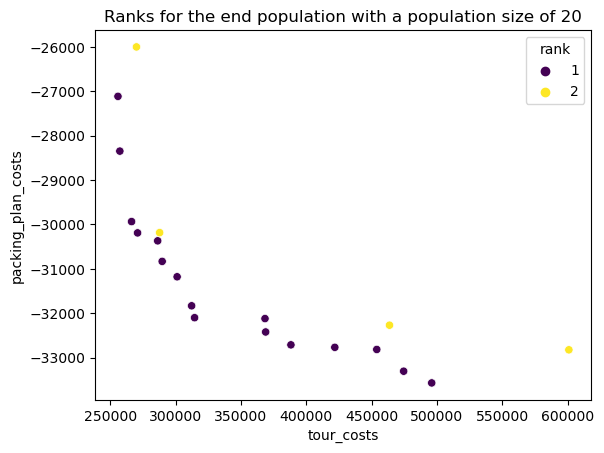

In [148]:
a280_n279_pop_size_20_exp_end_populations = pd.read_csv('../experimental_data/a280_n279_pop_size_20_exp_end_populations_trial_1.csv', sep = ";")
a280_n279_pop_size_20_exp_end_populations.head()
sns.scatterplot(x = a280_n279_pop_size_20_exp_end_populations["tour_costs"], 
                y = a280_n279_pop_size_20_exp_end_populations["packing_plan_costs"] * -1, 
                hue = a280_n279_pop_size_20_exp_end_populations["rank"], 
                palette="viridis"
                ).set(title = "Ranks for the end population with a population size of 20")

[Text(0.5, 1.0, 'Ranks for the end population with a population size of 40')]

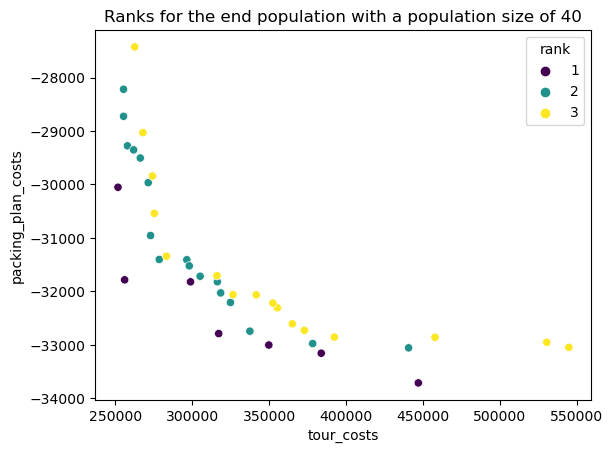

In [149]:
a280_n279_pop_size_40_exp_end_populations = pd.read_csv('../experimental_data/a280_n279_pop_size_40_exp_end_populations_trial_1.csv', sep = ";")
a280_n279_pop_size_40_exp_end_populations.head()
sns.scatterplot(x = a280_n279_pop_size_40_exp_end_populations["tour_costs"], 
                y = a280_n279_pop_size_40_exp_end_populations["packing_plan_costs"] * -1, 
                hue = a280_n279_pop_size_40_exp_end_populations["rank"], 
                palette="viridis"
                ).set(title = "Ranks for the end population with a population size of 40")

[Text(0.5, 1.0, 'Ranks for the end population with a population size of 60')]

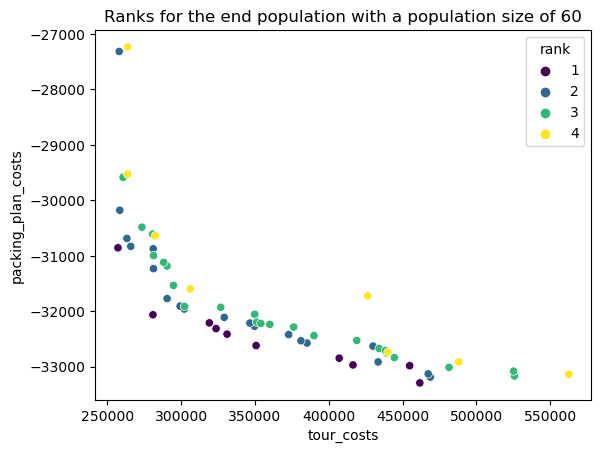

In [150]:
a280_n279_pop_size_60_exp_end_populations = pd.read_csv('../experimental_data/a280_n279_pop_size_60_exp_end_populations_trial_1.csv', sep = ";")
a280_n279_pop_size_60_exp_end_populations.head()
sns.scatterplot(x = a280_n279_pop_size_60_exp_end_populations["tour_costs"], 
                y = a280_n279_pop_size_60_exp_end_populations["packing_plan_costs"] * -1, 
                hue = a280_n279_pop_size_60_exp_end_populations["rank"], 
                palette="viridis"
                ).set(title = "Ranks for the end population with a population size of 60")

[Text(0.5, 1.0, 'Ranks for the end population with a population size of 80')]

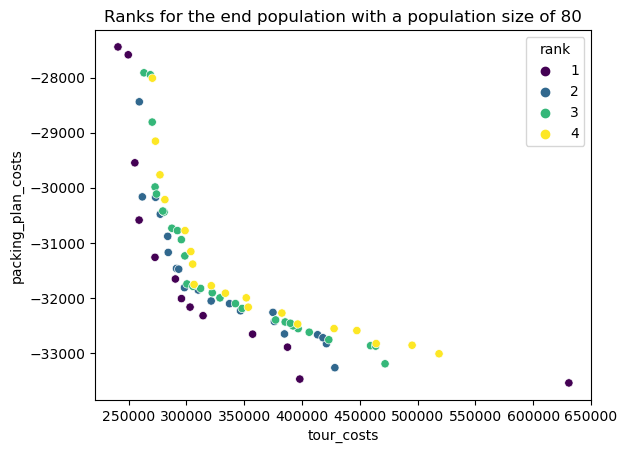

In [151]:
a280_n279_pop_size_80_exp_end_populations = pd.read_csv('../experimental_data/a280_n279_pop_size_80_exp_end_populations_trial_1.csv', sep = ";")
a280_n279_pop_size_80_exp_end_populations.head()
sns.scatterplot(x = a280_n279_pop_size_80_exp_end_populations["tour_costs"], 
                y = a280_n279_pop_size_80_exp_end_populations["packing_plan_costs"] * -1, 
                hue = a280_n279_pop_size_80_exp_end_populations["rank"], 
                palette="viridis"
                ).set(title = "Ranks for the end population with a population size of 80")

[Text(0.5, 1.0, 'Ranks for the end population with a population size of 100')]

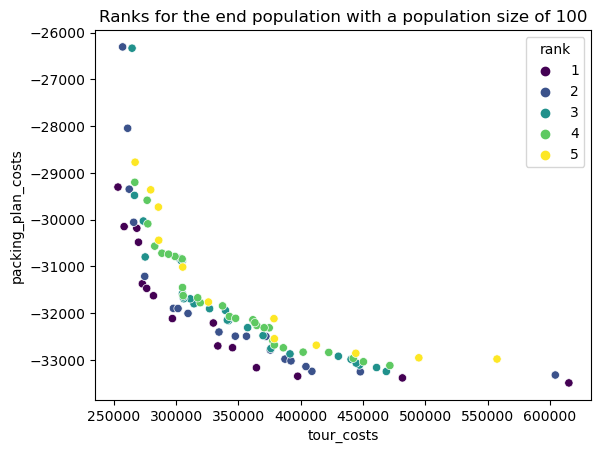

In [152]:
a280_n279_pop_size_100_exp_end_populations = pd.read_csv('../experimental_data/a280_n279_pop_size_100_exp_end_populations_trial_1.csv', sep = ";")
a280_n279_pop_size_100_exp_end_populations.head()
sns.scatterplot(x = a280_n279_pop_size_100_exp_end_populations["tour_costs"], 
                y = a280_n279_pop_size_100_exp_end_populations["packing_plan_costs"] * -1, 
                hue = a280_n279_pop_size_100_exp_end_populations["rank"], 
                palette="viridis"
                ).set(title = "Ranks for the end population with a population size of 100")

Plot all the pareto fronts for different population sizes

[Text(0.5, 1.0, 'Pareto fronts for the different population sizes')]

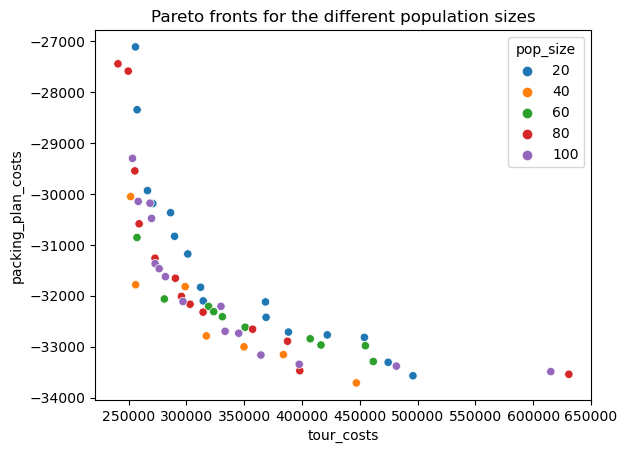

In [153]:
a280_n279_pop_size_20_exp_end_populations["pop_size"] = "20"
a280_n279_pop_size_40_exp_end_populations["pop_size"] = "40"
a280_n279_pop_size_60_exp_end_populations["pop_size"] = "60"
a280_n279_pop_size_80_exp_end_populations["pop_size"] = "80"
a280_n279_pop_size_100_exp_end_populations["pop_size"] = "100"

all_pop_size_exp = pd.concat([a280_n279_pop_size_20_exp_end_populations, 
                                a280_n279_pop_size_40_exp_end_populations, 
                                a280_n279_pop_size_60_exp_end_populations, 
                                a280_n279_pop_size_80_exp_end_populations,
                                a280_n279_pop_size_100_exp_end_populations])
all_pop_size_exp_pareto = all_pop_size_exp[all_pop_size_exp["rank"] == 1]

sns.scatterplot(x = all_pop_size_exp_pareto["tour_costs"], 
                y = all_pop_size_exp_pareto["packing_plan_costs"] * -1, 
                hue = all_pop_size_exp_pareto["pop_size"]
                ).set(title = "Pareto fronts for the different population sizes")


### Crossover Type

Experiment on different crossover types:
- No crossover
- Only OX1 Crossover for the tour
- randomly choose between OX1 crossover for the tour and single point crossover for the packing plan
- randomly choose between OX1 crossover for the tour and two point crossover for the packing plan

Only OX1

In [154]:
# pop_size = 60
# population = generate_initial_population(pop_size, a280_n279_nb_cities, "pack_random", "random", a280_n279_Q, a280_n279_value_to_weight_ratio_dict, a280_n279_item_weights)
# for candidate_solution in population:
#     evaluate_candidate_solution_cost_pdist(
#         candidate_solution, 
#         a280_n279_pairwise_distances,
#         a280_n279_item_to_city_mapping_dict, 
#         a280_n279_item_weights,
#         a280_n279_item_values,
#         a280_n279_vmax, 
#         a280_n279_vmin,  
#         a280_n279_Q,
#         a280_n279_R
#     )
# get_ranks(population)
# get_crowding_distance(population)
# for i in range(max_gen):
#     print(i)
#     children = []
#     for _ in range(int(pop_size / 2)):
#         parent1 = tournament_selection(population)
#         parent2 = tournament_selection(population)
#         child1, child2 = OX1_tour_crossover(parent1, parent2)
#         child1, child2 = tour_mutation(child1, child2, "single_swap")
#         child1, child2 = packing_plan_mutation(child1, child2, 0.2)
#         repair_packing_plan(child1, a280_n279_Q, a280_n279_item_weights)
#         repair_packing_plan(child2, a280_n279_Q, a280_n279_item_weights)
        
        

#         children.append(child1)
#         children.append(child2)
    
#     for child in children:
#         evaluate_candidate_solution_cost_pdist(
#             child, 
#             a280_n279_pairwise_distances,
#             a280_n279_item_to_city_mapping_dict, 
#             a280_n279_item_weights,
#             a280_n279_item_values,
#             a280_n279_vmax, 
#             a280_n279_vmin,  
#             a280_n279_Q,
#             a280_n279_R
#         )

#     population += children
#     get_ranks(population)
#     get_crowding_distance(population)
#     population = replacement(population, pop_size)

# pd.DataFrame({"tours": [sol.tour for sol in population], 
#               "packing_plans": [sol.packing_plan for sol in population],
#               "tour_costs": [sol.tour_cost for sol in population],
#               "packing_plan_costs": [sol.packing_plan_cost for sol in population],
#               "rank": [sol.rank for sol in population],
#               "crowding_distance": [sol.crowding_distance for sol in population]
#               }).to_csv('../experimental_data/a280_n279_cross_type_only_OX1_exp_end_populations.csv', sep = ";")

In [155]:
a280_n279_cross_type_only_OX1_exp_end_populations_data = pd.read_csv('../experimental_data/a280_n279_cross_type_only_OX1_exp_end_populations.csv', sep = ";")

In [156]:
a280_n279_cross_type_only_OX1_exp_end_populations_data.head()

,Unnamed: 0,tours,packing_plans,tour_costs,packing_plan_costs,rank,crowding_distance
0,0,"[269, 179, 166, 79, 251, 141, 190, 273, 227, 2...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",421070.676427,33730,1,inf
1,1,"[141, 113, 82, 59, 92, 132, 106, 190, 102, 46,...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...",242438.703874,27685,1,inf
2,2,"[9, 177, 98, 83, 243, 161, 123, 19, 110, 227, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, ...",246689.163131,28699,1,0.589759
3,3,"[141, 113, 82, 59, 92, 132, 106, 190, 102, 46,...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",268002.599176,30385,1,0.519741
4,4,"[141, 113, 82, 59, 92, 132, 106, 190, 102, 46,...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",295527.206877,31936,1,0.391485


[Text(0.5, 1.0, 'Visualising the Ranks of the Solutions Obtained Using\n only OX1 Crossover for the Tour Plans')]

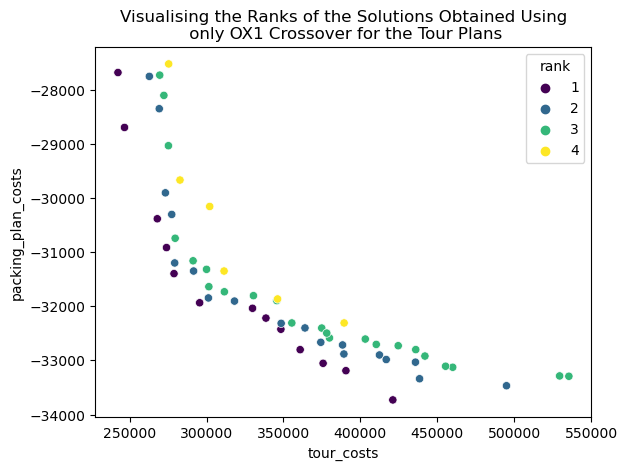

In [157]:
sns.scatterplot(x = a280_n279_cross_type_only_OX1_exp_end_populations_data["tour_costs"], 
                y = a280_n279_cross_type_only_OX1_exp_end_populations_data["packing_plan_costs"] * -1, 
                hue = a280_n279_cross_type_only_OX1_exp_end_populations_data["rank"], 
                palette="viridis"
                ).set(title = "Visualising the Ranks of the Solutions Obtained Using\n only OX1 Crossover for the Tour Plans")

No crossover

In [158]:
# pop_size = 60
# population = generate_initial_population(pop_size, a280_n279_nb_cities, "pack_random", "random", a280_n279_Q, a280_n279_value_to_weight_ratio_dict, a280_n279_item_weights)
# for candidate_solution in population:
#     evaluate_candidate_solution_cost_pdist(
#         candidate_solution, 
#         a280_n279_pairwise_distances,
#         a280_n279_item_to_city_mapping_dict, 
#         a280_n279_item_weights,
#         a280_n279_item_values,
#         a280_n279_vmax, 
#         a280_n279_vmin,  
#         a280_n279_Q,
#         a280_n279_R
#     )
# get_ranks(population)
# get_crowding_distance(population)
# for i in range(max_gen):
#     print(i)
#     children = []
#     for _ in range(int(pop_size / 2)):
#         parent1 = tournament_selection(population)
#         parent2 = tournament_selection(population)

#         child1, child2 = tour_mutation(parent1, parent2, "single_swap")
#         child1, child2 = packing_plan_mutation(child1, child2, 0.2)
#         repair_packing_plan(child1, a280_n279_Q, a280_n279_item_weights)
#         repair_packing_plan(child2, a280_n279_Q, a280_n279_item_weights)
        
        

#         children.append(child1)
#         children.append(child2)
    
#     for child in children:
#         evaluate_candidate_solution_cost_pdist(
#             child, 
#             a280_n279_pairwise_distances,
#             a280_n279_item_to_city_mapping_dict, 
#             a280_n279_item_weights,
#             a280_n279_item_values,
#             a280_n279_vmax, 
#             a280_n279_vmin,  
#             a280_n279_Q,
#             a280_n279_R
#         )

#     population += children
#     get_ranks(population)
#     get_crowding_distance(population)
#     population = replacement(population, pop_size)

# pd.DataFrame({"tours": [sol.tour for sol in population], 
#             "packing_plans": [sol.packing_plan for sol in population],
#             "tour_costs": [sol.tour_cost for sol in population],
#             "packing_plan_costs": [sol.packing_plan_cost for sol in population],
#             "rank": [sol.rank for sol in population],
#             "crowding_distance": [sol.crowding_distance for sol in population]
#             }).to_csv('../experimental_data/a280_n279_cross_type_no_cross_exp_end_populations.csv', sep = ";")

In [159]:
a280_n279_cross_type_no_cross_exp_end_populations = pd.read_csv('../experimental_data/a280_n279_cross_type_no_cross_exp_end_populations.csv', sep = ";")

In [160]:
a280_n279_cross_type_no_cross_exp_end_populations.head()

,Unnamed: 0,tours,packing_plans,tour_costs,packing_plan_costs,rank,crowding_distance
0,0,"[169, 175, 67, 131, 129, 163, 195, 80, 228, 12...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",377194.830647,33349,1,inf
1,1,"[229, 131, 94, 270, 130, 179, 188, 149, 78, 13...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",236464.713383,26507,1,inf
2,2,"[229, 131, 94, 270, 130, 179, 188, 149, 78, 13...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",244524.174939,28636,1,0.438892
3,3,"[229, 131, 94, 270, 130, 179, 188, 149, 78, 13...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",310269.882635,32452,1,0.394605
4,4,"[229, 131, 94, 270, 130, 179, 188, 149, 78, 13...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",249794.988841,30436,1,0.368107


[Text(0.5, 1.0, 'Visualising the Ranks of the Solutions Obtained Using\nno Crossover')]

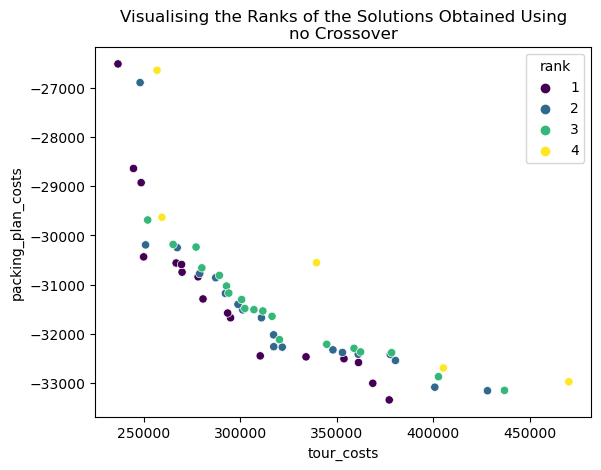

In [161]:
sns.scatterplot(x = a280_n279_cross_type_no_cross_exp_end_populations["tour_costs"], 
                y = a280_n279_cross_type_no_cross_exp_end_populations["packing_plan_costs"] * -1, 
                hue = a280_n279_cross_type_no_cross_exp_end_populations["rank"], 
                palette="viridis"
                ).set(title = "Visualising the Ranks of the Solutions Obtained Using\nno Crossover")

Randomly choose between OX1 tour crossover and single point packing plan crossover

In [162]:
# pop_size = 60
# population = generate_initial_population(pop_size, a280_n279_nb_cities, "pack_random", "random", a280_n279_Q, a280_n279_value_to_weight_ratio_dict, a280_n279_item_weights)
# for candidate_solution in population:
#     evaluate_candidate_solution_cost_pdist(
#         candidate_solution, 
#         a280_n279_pairwise_distances,
#         a280_n279_item_to_city_mapping_dict, 
#         a280_n279_item_weights,
#         a280_n279_item_values,
#         a280_n279_vmax, 
#         a280_n279_vmin,  
#         a280_n279_Q,
#         a280_n279_R
#     )
# get_ranks(population)
# get_crowding_distance(population)
# for i in range(max_gen):
#     print(i)
#     children = []
#     for _ in range(int(pop_size / 2)):
#         parent1 = tournament_selection(population)
#         parent2 = tournament_selection(population)

#         x = np.random.random(1)

#         if x < 0.5:
#             child1, child2 = OX1_tour_crossover(parent1, parent2)
#         else:
#             child1, child2 = packing_plan_crossover(parent1, parent2, "single_point")
#             child1.tour = derive_tour_from_packing_plan(child1, a280_n279_item_to_city_mapping_dict, a280_n279_item_weights)
#             child2.tour = derive_tour_from_packing_plan(child2, a280_n279_item_to_city_mapping_dict, a280_n279_item_weights)
            

#         child1, child2 = tour_mutation(child1, child2, "single_swap")
#         child1, child2 = packing_plan_mutation(child1, child2, 0.2)
#         repair_packing_plan(child1, a280_n279_Q, a280_n279_item_weights)
#         repair_packing_plan(child2, a280_n279_Q, a280_n279_item_weights)
        
        

#         children.append(child1)
#         children.append(child2)
    
#     for child in children:
#         evaluate_candidate_solution_cost_pdist(
#             child, 
#             a280_n279_pairwise_distances,
#             a280_n279_item_to_city_mapping_dict, 
#             a280_n279_item_weights,
#             a280_n279_item_values,
#             a280_n279_vmax, 
#             a280_n279_vmin,  
#             a280_n279_Q,
#             a280_n279_R
#         )

#     population += children
#     get_ranks(population)
#     get_crowding_distance(population)
#     population = replacement(population, pop_size)

# pd.DataFrame({"tours": [sol.tour for sol in population], 
#             "packing_plans": [sol.packing_plan for sol in population],
#             "tour_costs": [sol.tour_cost for sol in population],
#             "packing_plan_costs": [sol.packing_plan_cost for sol in population],
#             "rank": [sol.rank for sol in population],
#             "crowding_distance": [sol.crowding_distance for sol in population]
#             }).to_csv('../experimental_data/a280_n279_cross_type_OX1_single_point_exp_end_populations.csv', sep = ";")

In [163]:
a280_n279_cross_type_OX1_single_point_exp_end_populations = pd.read_csv('../experimental_data/a280_n279_cross_type_OX1_single_point_exp_end_populations.csv', sep = ";")

In [164]:
a280_n279_cross_type_OX1_single_point_exp_end_populations.head()

,Unnamed: 0,tours,packing_plans,tour_costs,packing_plan_costs,rank,crowding_distance
0,0,"[243, 252, 230, 69, 219, 41, 157, 141, 45, 126...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",223014.210434,30387,1,inf
1,1,"[19, 170, 200, 108, 112, 37, 191, 68, 41, 136,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...",291708.226902,33441,1,inf
2,2,"[19, 170, 200, 108, 112, 37, 191, 68, 41, 136,...","[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",244366.034966,32134,1,0.835385
3,3,"[225, 27, 265, 31, 157, 90, 193, 17, 231, 239,...","[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...",240469.092757,30931,1,0.791646
4,4,"[226, 254, 231, 5, 247, 137, 141, 243, 210, 26...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",259347.622742,33058,1,0.732392


[Text(0.5, 1.0, 'Visualising the Ranks of the Solutions Obtained When Randomly \n Using Either OX1 Crossover for the Tour or Single Point Crossover for the Packing Plan')]

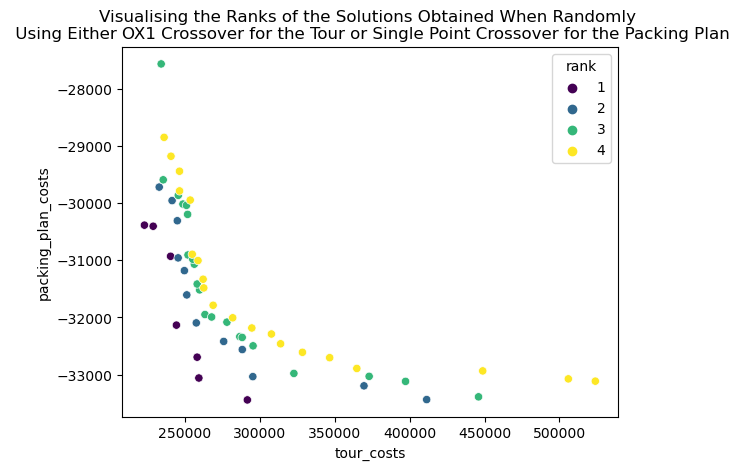

In [165]:
sns.scatterplot(x = a280_n279_cross_type_OX1_single_point_exp_end_populations["tour_costs"], 
                y = a280_n279_cross_type_OX1_single_point_exp_end_populations["packing_plan_costs"] * -1, 
                hue = a280_n279_cross_type_OX1_single_point_exp_end_populations["rank"], 
                palette="viridis"
                ).set(title = "Visualising the Ranks of the Solutions Obtained When Randomly \n Using Either OX1 Crossover for the Tour or Single Point Crossover for the Packing Plan")

Randomly choose between OX1 tour crossover and two point packing plan crossover

In [166]:
# pop_size = 60
# population = generate_initial_population(pop_size, a280_n279_nb_cities, "pack_random", "random", a280_n279_Q, a280_n279_value_to_weight_ratio_dict, a280_n279_item_weights)
# for candidate_solution in population:
#     evaluate_candidate_solution_cost_pdist(
#         candidate_solution, 
#         a280_n279_pairwise_distances,
#         a280_n279_item_to_city_mapping_dict, 
#         a280_n279_item_weights,
#         a280_n279_item_values,
#         a280_n279_vmax, 
#         a280_n279_vmin,  
#         a280_n279_Q,
#         a280_n279_R
#     )
# get_ranks(population)
# get_crowding_distance(population)
# for i in range(max_gen):
#     print(i)
#     children = []
#     for _ in range(int(pop_size / 2)):
#         parent1 = tournament_selection(population)
#         parent2 = tournament_selection(population)

#         x = np.random.random(1)

#         if x < 0.5:
#             child1, child2 = OX1_tour_crossover(parent1, parent2)
#         else:
#             child1, child2 = packing_plan_crossover(parent1, parent2, "two_point")
#             child1.tour = derive_tour_from_packing_plan(child1, a280_n279_item_to_city_mapping_dict, a280_n279_item_weights)
#             child2.tour = derive_tour_from_packing_plan(child2, a280_n279_item_to_city_mapping_dict, a280_n279_item_weights)
            

#         child1, child2 = tour_mutation(child1, child2, "single_swap")
#         child1, child2 = packing_plan_mutation(child1, child2, 0.2)
#         repair_packing_plan(child1, a280_n279_Q, a280_n279_item_weights)
#         repair_packing_plan(child2, a280_n279_Q, a280_n279_item_weights)
        
        

#         children.append(child1)
#         children.append(child2)
    
#     for child in children:
#         evaluate_candidate_solution_cost_pdist(
#             child, 
#             a280_n279_pairwise_distances,
#             a280_n279_item_to_city_mapping_dict, 
#             a280_n279_item_weights,
#             a280_n279_item_values,
#             a280_n279_vmax, 
#             a280_n279_vmin,  
#             a280_n279_Q,
#             a280_n279_R
#         )

# population += children
# get_ranks(population)
# get_crowding_distance(population)
# population = replacement(population, pop_size)

# pd.DataFrame({"tours": [sol.tour for sol in population], 
#             "packing_plans": [sol.packing_plan for sol in population],
#             "tour_costs": [sol.tour_cost for sol in population],
#             "packing_plan_costs": [sol.packing_plan_cost for sol in population],
#             "rank": [sol.rank for sol in population],
#             "crowding_distance": [sol.crowding_distance for sol in population]
#             }).to_csv('../experimental_data/a280_n279_cross_type_OX1_two_point_exp_end_populations.csv', sep = ";")

In [167]:
a280_n279_cross_type_OX1_two_point_exp_end_populations = pd.read_csv('../experimental_data/a280_n279_cross_type_OX1_two_point_exp_end_populations.csv', sep = ";")

In [168]:
a280_n279_cross_type_OX1_two_point_exp_end_populations.head()

,Unnamed: 0,tours,packing_plans,tour_costs,packing_plan_costs,rank,crowding_distance
0,0,"[208, 251, 273, 59, 209, 244, 23, 32, 94, 245,...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",574112.334082,32122,1,inf
1,1,"[225, 38, 162, 96, 222, 50, 89, 87, 95, 250, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...",275993.927570,30513,1,inf
2,2,"[107, 74, 18, 127, 0, 85, 50, 153, 147, 159, 2...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",374575.834009,32010,1,1.102349
3,3,"[143, 158, 156, 151, 279, 180, 172, 81, 159, 5...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",341272.491378,31605,1,0.716098
4,4,"[0, 190, 131, 254, 50, 162, 81, 157, 117, 18, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",332479.431838,31085,1,0.634113


[Text(0.5, 1.0, 'Visualising the Ranks of the Solutions Obtained When Randomly \n Using Either OX1 Crossover for the Tour or Two Point Crossover for the Packing Plan')]

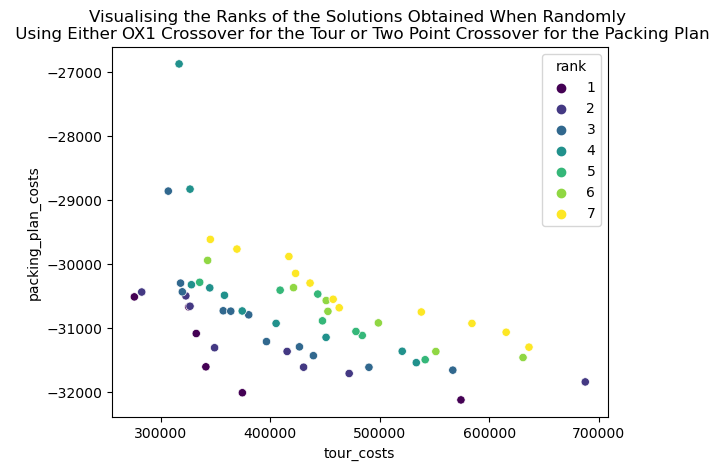

In [169]:
sns.scatterplot(x = a280_n279_cross_type_OX1_two_point_exp_end_populations["tour_costs"], 
                y = a280_n279_cross_type_OX1_two_point_exp_end_populations["packing_plan_costs"] * -1, 
                hue = a280_n279_cross_type_OX1_two_point_exp_end_populations["rank"], 
                palette="viridis"
                ).set(title = "Visualising the Ranks of the Solutions Obtained When Randomly \n Using Either OX1 Crossover for the Tour or Two Point Crossover for the Packing Plan")

Plot all the pareto fronts for the crossover type experiments

[Text(0.5, 1.0, 'Comparing the Pareto Fronts For the Different Crossover Types')]

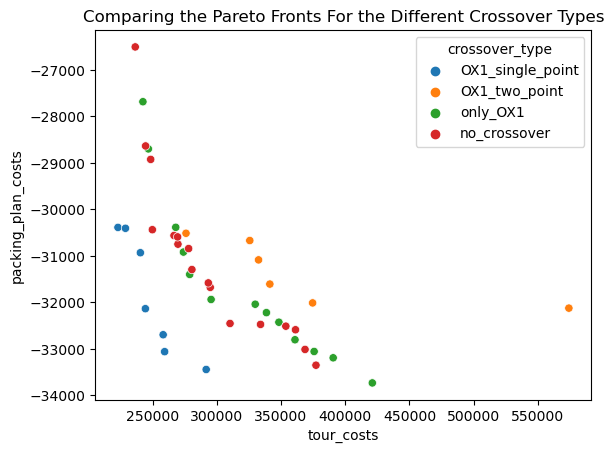

In [170]:
a280_n279_cross_type_OX1_single_point_exp_end_populations["crossover_type"] = "OX1_single_point"
a280_n279_cross_type_OX1_two_point_exp_end_populations["crossover_type"] = "OX1_two_point"
a280_n279_cross_type_only_OX1_exp_end_populations_data["crossover_type"] = "only_OX1"
a280_n279_cross_type_no_cross_exp_end_populations["crossover_type"] = "no_crossover"

all_cross_type_exp = pd.concat([a280_n279_cross_type_OX1_single_point_exp_end_populations, a280_n279_cross_type_OX1_two_point_exp_end_populations, a280_n279_cross_type_only_OX1_exp_end_populations_data, a280_n279_cross_type_no_cross_exp_end_populations])
all_cross_type_exp_pareto = all_cross_type_exp[all_cross_type_exp["rank"] == 1]

sns.scatterplot(x = all_cross_type_exp_pareto["tour_costs"], 
                y = all_cross_type_exp_pareto["packing_plan_costs"] * -1, 
                hue = all_cross_type_exp_pareto["crossover_type"]
                ).set(title = "Comparing the Pareto Fronts For the Different Crossover Types")


### Mutations

#### Mutation Types for the Tour:
- Inversion Mutation
- Single swap

In [171]:
# pop_size = 60
# mutation_types = ["inversion", "single_swap"]

# for mutation_type in mutation_types:
#     population = generate_initial_population(pop_size, a280_n279_nb_cities, "pack_random", "random", a280_n279_Q, a280_n279_value_to_weight_ratio_dict, a280_n279_item_weights)
#     for candidate_solution in population:
#         evaluate_candidate_solution_cost_pdist(
#             candidate_solution, 
#             a280_n279_pairwise_distances,
#             a280_n279_item_to_city_mapping_dict, 
#             a280_n279_item_weights,
#             a280_n279_item_values,
#             a280_n279_vmax, 
#             a280_n279_vmin,  
#             a280_n279_Q,
#             a280_n279_R
#         )
#     get_ranks(population)
#     get_crowding_distance(population)
#     for i in range(max_gen):
#         print(f"Mutation Type: {mutation_type}, Gen: {i}")
#         children = []
#         for _ in range(int(pop_size / 2)):
#             parent1 = tournament_selection(population)
#             parent2 = tournament_selection(population)
#             child1, child2 = OX1_tour_crossover(parent1, parent2)
#             child1, child2 = tour_mutation(child1, child2, mutation_type)
#             child1, child2 = packing_plan_mutation(child1, child2, 0.2)
#             repair_packing_plan(child1, a280_n279_Q, a280_n279_item_weights)
#             repair_packing_plan(child2, a280_n279_Q, a280_n279_item_weights)
            
            

#             children.append(child1)
#             children.append(child2)
        
#         for child in children:
#             evaluate_candidate_solution_cost_pdist(
#                 child, 
#                 a280_n279_pairwise_distances,
#                 a280_n279_item_to_city_mapping_dict, 
#                 a280_n279_item_weights,
#                 a280_n279_item_values,
#                 a280_n279_vmax, 
#                 a280_n279_vmin,  
#                 a280_n279_Q,
#                 a280_n279_R
#             )

#         population += children
#         get_ranks(population)
#         get_crowding_distance(population)
#         population = replacement(population, pop_size)

#     pd.DataFrame({"tours": [sol.tour for sol in population], 
#                 "packing_plans": [sol.packing_plan for sol in population],
#                 "tour_costs": [sol.tour_cost for sol in population],
#                 "packing_plan_costs": [sol.packing_plan_cost for sol in population],
#                 "rank": [sol.rank for sol in population],
#                 "crowding_distance": [sol.crowding_distance for sol in population]
#                 }).to_csv(f'../experimental_data/a280_n279_tour_mutation_type_{mutation_type}_exp_end_populations.csv', sep = ";")

Inversion

[Text(0.5, 1.0, 'Visualising the Ranks of the Solutions Obtained When Using Inversion \n Mutation on the Tour Plans')]

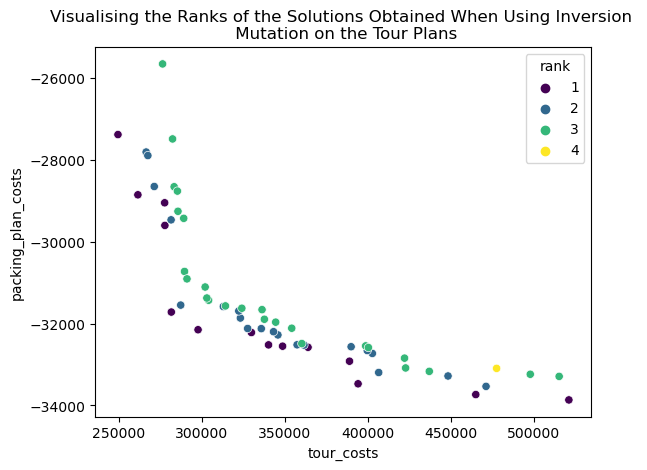

In [172]:
a280_n279_tour_mutation_type_inversion_exp_end_populations = pd.read_csv('../experimental_data/a280_n279_tour_mutation_type_inversion_exp_end_populations.csv', sep = ";")
sns.scatterplot(x = a280_n279_tour_mutation_type_inversion_exp_end_populations["tour_costs"], 
                y = a280_n279_tour_mutation_type_inversion_exp_end_populations["packing_plan_costs"] * -1, 
                hue = a280_n279_tour_mutation_type_inversion_exp_end_populations["rank"], 
                palette="viridis"
                ).set(title = "Visualising the Ranks of the Solutions Obtained When Using Inversion \n Mutation on the Tour Plans")

Single Swap

[Text(0.5, 1.0, 'Visualising the Ranks of the Solutions Obtained When Using Single Swap \n Mutation on the Tour Plans')]

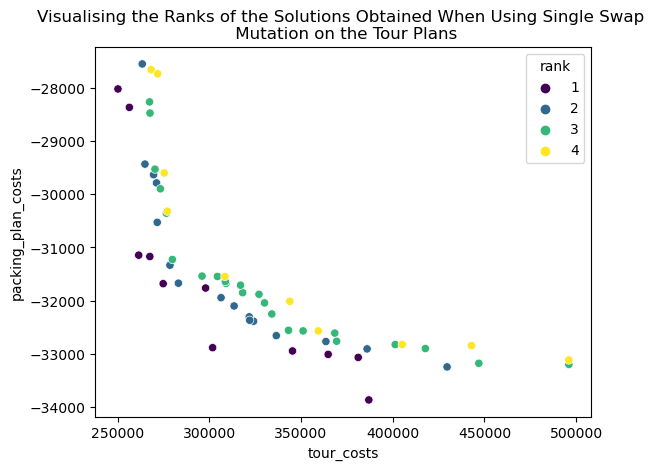

In [173]:
a280_n279_tour_mutation_type_single_swap_exp_end_populations = pd.read_csv('../experimental_data/a280_n279_tour_mutation_type_single_swap_exp_end_populations.csv', sep = ";")
sns.scatterplot(x = a280_n279_tour_mutation_type_single_swap_exp_end_populations["tour_costs"], 
                y = a280_n279_tour_mutation_type_single_swap_exp_end_populations["packing_plan_costs"] * -1, 
                hue = a280_n279_tour_mutation_type_single_swap_exp_end_populations["rank"], 
                palette="viridis"
                ).set(title = "Visualising the Ranks of the Solutions Obtained When Using Single Swap \n Mutation on the Tour Plans")

[Text(0.5, 1.0, 'Comparing the Pareto Fronts For the Different Tour Plan Mutation Types')]

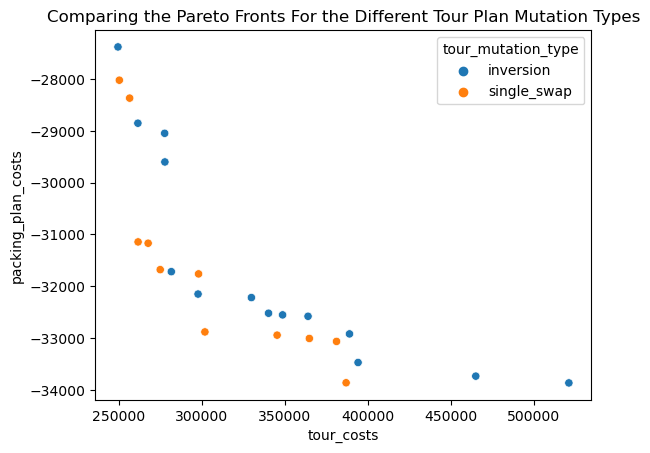

In [174]:
a280_n279_tour_mutation_type_inversion_exp_end_populations["tour_mutation_type"] = "inversion"
a280_n279_tour_mutation_type_single_swap_exp_end_populations["tour_mutation_type"] = "single_swap"

all_mut_type_exp = pd.concat([a280_n279_tour_mutation_type_inversion_exp_end_populations, 
                                a280_n279_tour_mutation_type_single_swap_exp_end_populations])
all_mut_type_exp_pareto = all_mut_type_exp[all_mut_type_exp["rank"] == 1]

sns.scatterplot(x = all_mut_type_exp_pareto["tour_costs"], 
                y = all_mut_type_exp_pareto["packing_plan_costs"] * -1, 
                hue = all_mut_type_exp_pareto["tour_mutation_type"]
                ).set(title = "Comparing the Pareto Fronts For the Different Tour Plan Mutation Types")

#### Mutation Percentages for the Packing Plans

Vary percentages of bits which are flipped: 25%, 50%, 75%

In [175]:
# pop_size = 60
# mutation_percentages = [0.25, 0.50, 0.75]

# for mutation_percentage in mutation_percentages:
#     population = generate_initial_population(pop_size, a280_n279_nb_cities, "pack_random", "random", a280_n279_Q, a280_n279_value_to_weight_ratio_dict, a280_n279_item_weights)
#     for candidate_solution in population:
#         evaluate_candidate_solution_cost_pdist(
#             candidate_solution, 
#             a280_n279_pairwise_distances,
#             a280_n279_item_to_city_mapping_dict, 
#             a280_n279_item_weights,
#             a280_n279_item_values,
#             a280_n279_vmax, 
#             a280_n279_vmin,  
#             a280_n279_Q,
#             a280_n279_R
#         )
#     get_ranks(population)
#     get_crowding_distance(population)
#     for i in range(max_gen):
#         print(f"Mutation Perc: {mutation_percentage}, Gen: {i}")
#         children = []
#         for _ in range(int(pop_size / 2)):
#             parent1 = tournament_selection(population)
#             parent2 = tournament_selection(population)
#             child1, child2 = OX1_tour_crossover(parent1, parent2)
#             child1, child2 = tour_mutation(child1, child2, "single_swap")
#             child1, child2 = packing_plan_mutation(child1, child2, mutation_percentage)
#             repair_packing_plan(child1, a280_n279_Q, a280_n279_item_weights)
#             repair_packing_plan(child2, a280_n279_Q, a280_n279_item_weights)
            
            

#             children.append(child1)
#             children.append(child2)
        
#         for child in children:
#             evaluate_candidate_solution_cost_pdist(
#                 child, 
#                 a280_n279_pairwise_distances,
#                 a280_n279_item_to_city_mapping_dict, 
#                 a280_n279_item_weights,
#                 a280_n279_item_values,
#                 a280_n279_vmax, 
#                 a280_n279_vmin,  
#                 a280_n279_Q,
#                 a280_n279_R
#             )

#         population += children
#         get_ranks(population)
#         get_crowding_distance(population)
#         population = replacement(population, pop_size)

#     pd.DataFrame({"tours": [sol.tour for sol in population], 
#                 "packing_plans": [sol.packing_plan for sol in population],
#                 "tour_costs": [sol.tour_cost for sol in population],
#                 "packing_plan_costs": [sol.packing_plan_cost for sol in population],
#                 "rank": [sol.rank for sol in population],
#                 "crowding_distance": [sol.crowding_distance for sol in population]
#                 }).to_csv(f'../experimental_data/a280_n279_tour_mutation_perc_{str(mutation_percentage).replace(".", "")}_exp_end_populations.csv', sep = ";")

[Text(0.5, 1.0, 'Visualising the Ranks of the Solutions Obtained when \n the Bit Flip Mutation % is 25%')]

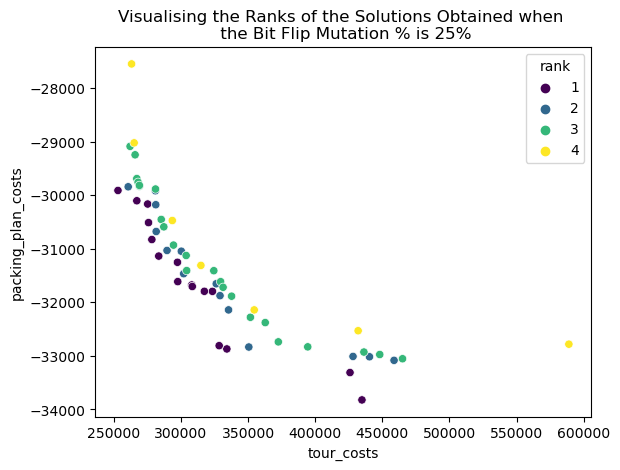

In [176]:
a280_n279_tour_mutation_perc_025_exp_end_populations = pd.read_csv('../experimental_data/a280_n279_tour_mutation_perc_025_exp_end_populations.csv', sep = ";")
sns.scatterplot(x = a280_n279_tour_mutation_perc_025_exp_end_populations["tour_costs"], 
                y = a280_n279_tour_mutation_perc_025_exp_end_populations["packing_plan_costs"] * -1, 
                hue = a280_n279_tour_mutation_perc_025_exp_end_populations["rank"], 
                palette="viridis"
                ).set(title = "Visualising the Ranks of the Solutions Obtained when \n the Bit Flip Mutation % is 25%")

[Text(0.5, 1.0, 'Visualising the Ranks of the Solutions Obtained when \n the Bit Flip Mutation % is 50%')]

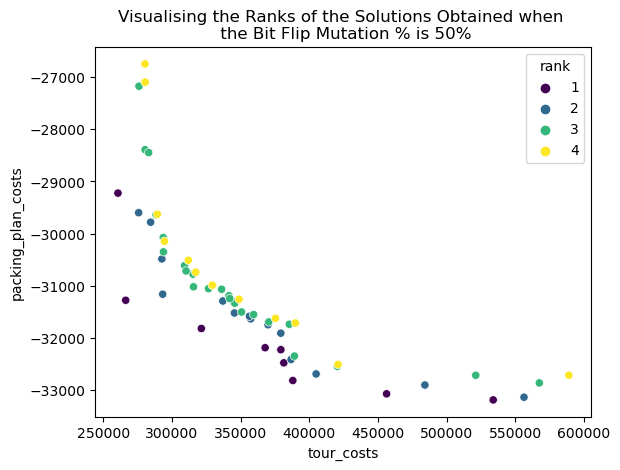

In [177]:
a280_n279_tour_mutation_perc_05_exp_end_populations = pd.read_csv('../experimental_data/a280_n279_tour_mutation_perc_05_exp_end_populations.csv', sep = ";")
sns.scatterplot(x = a280_n279_tour_mutation_perc_05_exp_end_populations["tour_costs"], 
                y = a280_n279_tour_mutation_perc_05_exp_end_populations["packing_plan_costs"] * -1, 
                hue = a280_n279_tour_mutation_perc_05_exp_end_populations["rank"], 
                palette="viridis"
                ).set(title = "Visualising the Ranks of the Solutions Obtained when \n the Bit Flip Mutation % is 50%")

[Text(0.5, 1.0, 'Visualising the Ranks of the Solutions Obtained when \n the Bit Flip Mutation % is 75%')]

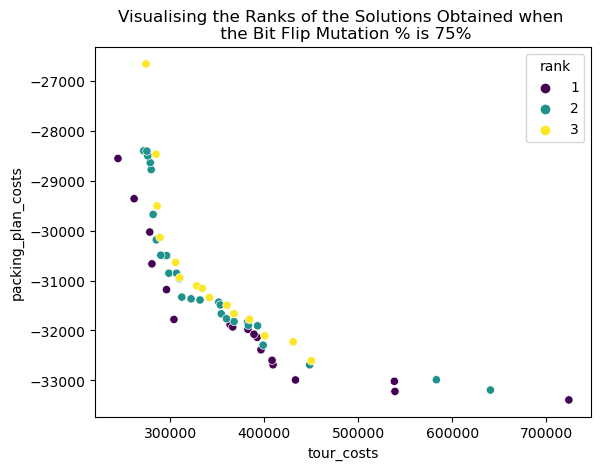

In [178]:
a280_n279_tour_mutation_perc_075_exp_end_populations = pd.read_csv('../experimental_data/a280_n279_tour_mutation_perc_075_exp_end_populations.csv', sep = ";")
sns.scatterplot(x = a280_n279_tour_mutation_perc_075_exp_end_populations["tour_costs"], 
                y = a280_n279_tour_mutation_perc_075_exp_end_populations["packing_plan_costs"] * -1, 
                hue = a280_n279_tour_mutation_perc_075_exp_end_populations["rank"], 
                palette="viridis"
                ).set(title = "Visualising the Ranks of the Solutions Obtained when \n the Bit Flip Mutation % is 75%")

[Text(0.5, 1.0, 'Comparing the Pareto Fronts For the Different Bit Flip \n Mutation %s of the Packing Plans')]

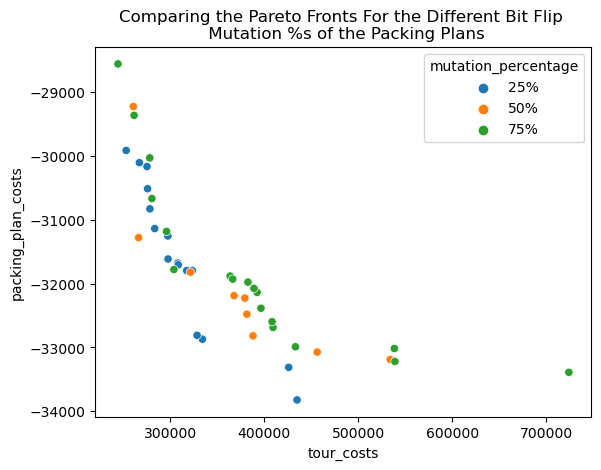

In [179]:
a280_n279_tour_mutation_perc_025_exp_end_populations["mutation_percentage"] = "25%"
a280_n279_tour_mutation_perc_05_exp_end_populations["mutation_percentage"] = "50%"
a280_n279_tour_mutation_perc_075_exp_end_populations["mutation_percentage"] = "75%"

all_mut_perc_exp = pd.concat([a280_n279_tour_mutation_perc_025_exp_end_populations, 
                                a280_n279_tour_mutation_perc_05_exp_end_populations,
                                a280_n279_tour_mutation_perc_075_exp_end_populations])
all_mut_perc_exp_pareto = all_mut_perc_exp[all_mut_perc_exp["rank"] == 1]

sns.scatterplot(x = all_mut_perc_exp_pareto["tour_costs"], 
                y = all_mut_perc_exp_pareto["packing_plan_costs"] * -1, 
                hue = all_mut_perc_exp_pareto["mutation_percentage"]
                ).set(title = "Comparing the Pareto Fronts For the Different Bit Flip \n Mutation %s of the Packing Plans")

### Packing Plan Initialisation Type
- random
- pack one
- pack optimal

In [180]:
# pop_size = 60
# packing_plan_init_methods = ["pack_optimal", "pack_random", "pack_one"]

# for packing_plan_init_method in packing_plan_init_methods:
#     population = generate_initial_population(pop_size, a280_n279_nb_cities, packing_plan_init_method, "random", a280_n279_Q, a280_n279_value_to_weight_ratio_dict, a280_n279_item_weights)
#     for candidate_solution in population:
#         evaluate_candidate_solution_cost_pdist(
#             candidate_solution, 
#             a280_n279_pairwise_distances,
#             a280_n279_item_to_city_mapping_dict, 
#             a280_n279_item_weights,
#             a280_n279_item_values,
#             a280_n279_vmax, 
#             a280_n279_vmin,  
#             a280_n279_Q,
#             a280_n279_R
#         )
#     get_ranks(population)
#     get_crowding_distance(population)
#     for i in range(max_gen):
#         print(f"Packing plan method: {packing_plan_init_method}, Gen: {i}")
#         children = []
#         for _ in range(int(pop_size / 2)):
#             parent1 = tournament_selection(population)
#             parent2 = tournament_selection(population)
#             child1, child2 = OX1_tour_crossover(parent1, parent2)
#             child1, child2 = tour_mutation(child1, child2, "single_swap")
#             child1, child2 = packing_plan_mutation(child1, child2, 0.25)
#             repair_packing_plan(child1, a280_n279_Q, a280_n279_item_weights)
#             repair_packing_plan(child2, a280_n279_Q, a280_n279_item_weights)
            
            

#             children.append(child1)
#             children.append(child2)
        
#         for child in children:
#             evaluate_candidate_solution_cost_pdist(
#                 child, 
#                 a280_n279_pairwise_distances,
#                 a280_n279_item_to_city_mapping_dict, 
#                 a280_n279_item_weights,
#                 a280_n279_item_values,
#                 a280_n279_vmax, 
#                 a280_n279_vmin,  
#                 a280_n279_Q,
#                 a280_n279_R
#             )

#         population += children
#         get_ranks(population)
#         get_crowding_distance(population)
#         population = replacement(population, pop_size)

#     pd.DataFrame({"tours": [sol.tour for sol in population], 
#                 "packing_plans": [sol.packing_plan for sol in population],
#                 "tour_costs": [sol.tour_cost for sol in population],
#                 "packing_plan_costs": [sol.packing_plan_cost for sol in population],
#                 "rank": [sol.rank for sol in population],
#                 "crowding_distance": [sol.crowding_distance for sol in population]
#                 }).to_csv(f'../experimental_data/a280_n279_packing_plan_init_{packing_plan_init_method}_exp_end_populations.csv', sep = ";")

[Text(0.5, 1.0, 'Ranks for the end population using an optimal initial packing plan')]

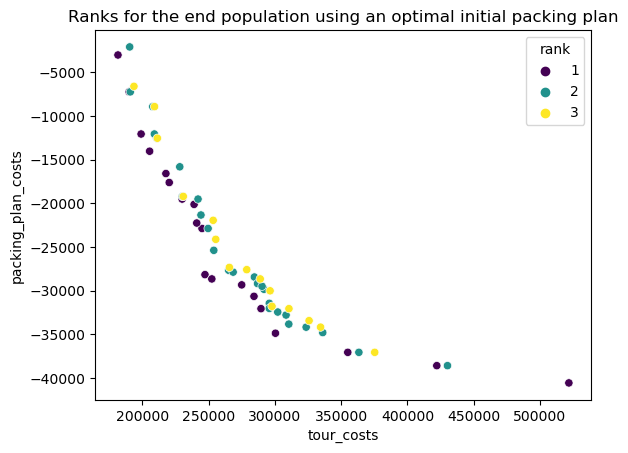

In [181]:
a280_n279_packing_plan_init_pack_optimal_exp_end_populations = pd.read_csv('../experimental_data/a280_n279_packing_plan_init_pack_optimal_exp_end_populations.csv', sep = ";")
sns.scatterplot(x = a280_n279_packing_plan_init_pack_optimal_exp_end_populations["tour_costs"], 
                y = a280_n279_packing_plan_init_pack_optimal_exp_end_populations["packing_plan_costs"] * -1, 
                hue = a280_n279_packing_plan_init_pack_optimal_exp_end_populations["rank"], 
                palette="viridis"
                ).set(title = "Ranks for the end population using an optimal initial packing plan")

[Text(0.5, 1.0, 'Ranks for the end population using a randomly initialised packing plan')]

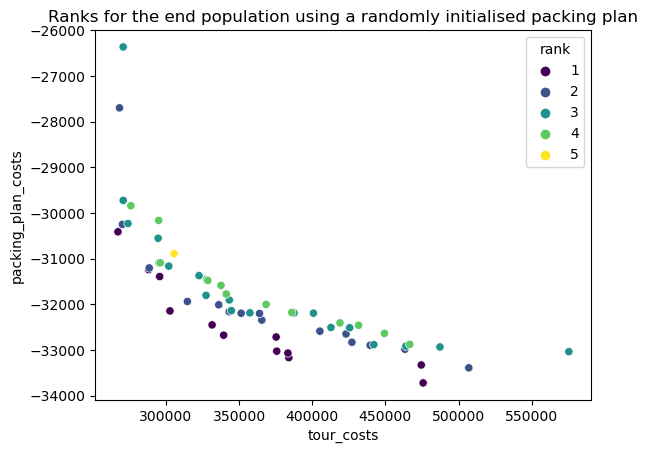

In [182]:
a280_n279_packing_plan_init_pack_random_exp_end_populations = pd.read_csv('../experimental_data/a280_n279_packing_plan_init_pack_random_exp_end_populations.csv', sep = ";")
sns.scatterplot(x = a280_n279_packing_plan_init_pack_random_exp_end_populations["tour_costs"], 
                y = a280_n279_packing_plan_init_pack_random_exp_end_populations["packing_plan_costs"] * -1, 
                hue = a280_n279_packing_plan_init_pack_random_exp_end_populations["rank"], 
                palette="viridis"
                ).set(title = "Ranks for the end population using a randomly initialised packing plan")

[Text(0.5, 1.0, 'Ranks for the end population using a pack one initial packing plan')]

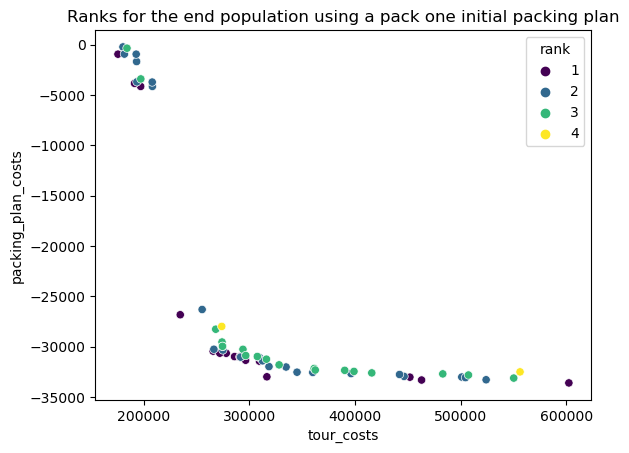

In [183]:
a280_n279_packing_plan_init_pack_one_exp_end_populations = pd.read_csv('../experimental_data/a280_n279_packing_plan_init_pack_one_exp_end_populations.csv', sep = ";")
sns.scatterplot(x = a280_n279_packing_plan_init_pack_one_exp_end_populations["tour_costs"], 
                y = a280_n279_packing_plan_init_pack_one_exp_end_populations["packing_plan_costs"] * -1, 
                hue = a280_n279_packing_plan_init_pack_one_exp_end_populations["rank"], 
                palette="viridis"
                ).set(title = "Ranks for the end population using a pack one initial packing plan")

[Text(0.5, 1.0, 'Comparing the Pareto Fronts For the Different Initial Methods Packing Plans')]

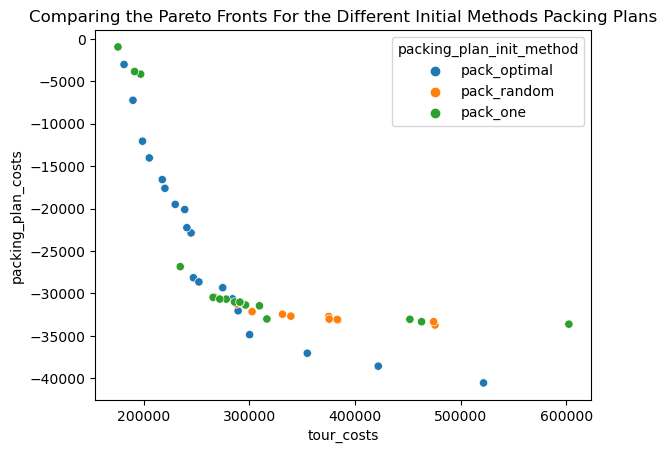

In [184]:
a280_n279_packing_plan_init_pack_optimal_exp_end_populations["packing_plan_init_method"] = "pack_optimal"
a280_n279_packing_plan_init_pack_random_exp_end_populations["packing_plan_init_method"] = "pack_random"
a280_n279_packing_plan_init_pack_one_exp_end_populations["packing_plan_init_method"] = "pack_one"

all_packing_plan_init_method_exp = pd.concat([a280_n279_packing_plan_init_pack_optimal_exp_end_populations, 
                                a280_n279_packing_plan_init_pack_random_exp_end_populations,
                                a280_n279_packing_plan_init_pack_one_exp_end_populations])
all_packing_plan_init_method_exp_pareto = all_packing_plan_init_method_exp[all_packing_plan_init_method_exp["rank"] == 1]

sns.scatterplot(x = all_packing_plan_init_method_exp_pareto["tour_costs"], 
                y = all_packing_plan_init_method_exp_pareto["packing_plan_costs"] * -1, 
                hue = all_packing_plan_init_method_exp_pareto["packing_plan_init_method"]
                ).set(title = "Comparing the Pareto Fronts For the Different Initial Methods Packing Plans")

Plotting all the experiment results

C:\Users\hpapa\AppData\Local\Temp\ipykernel_23044\1423900959.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0][0].set_xticklabels(axs[0][0].get_xticklabels(), rotation = 45, fontsize = 7)
C:\Users\hpapa\AppData\Local\Temp\ipykernel_23044\1423900959.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0][0].set_yticklabels(axs[0][0].get_yticklabels(), fontsize = 7)
C:\Users\hpapa\AppData\Local\Temp\ipykernel_23044\1423900959.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0][1].set_xticklabels(axs[0][1].get_xticklabels(), rotation = 45, fontsize = 7)
C:\Users\hpapa\AppData\Local\Temp\ipykernel_23044\1423900959.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0][1].set_yticklabels(axs[0][1].get_yticklabels(), fontsize = 7)
C:\Users\hpapa\AppData\Local\Temp\ipykernel_23044\1423900959.py:31: UserWarning: FixedFormatter should only be used

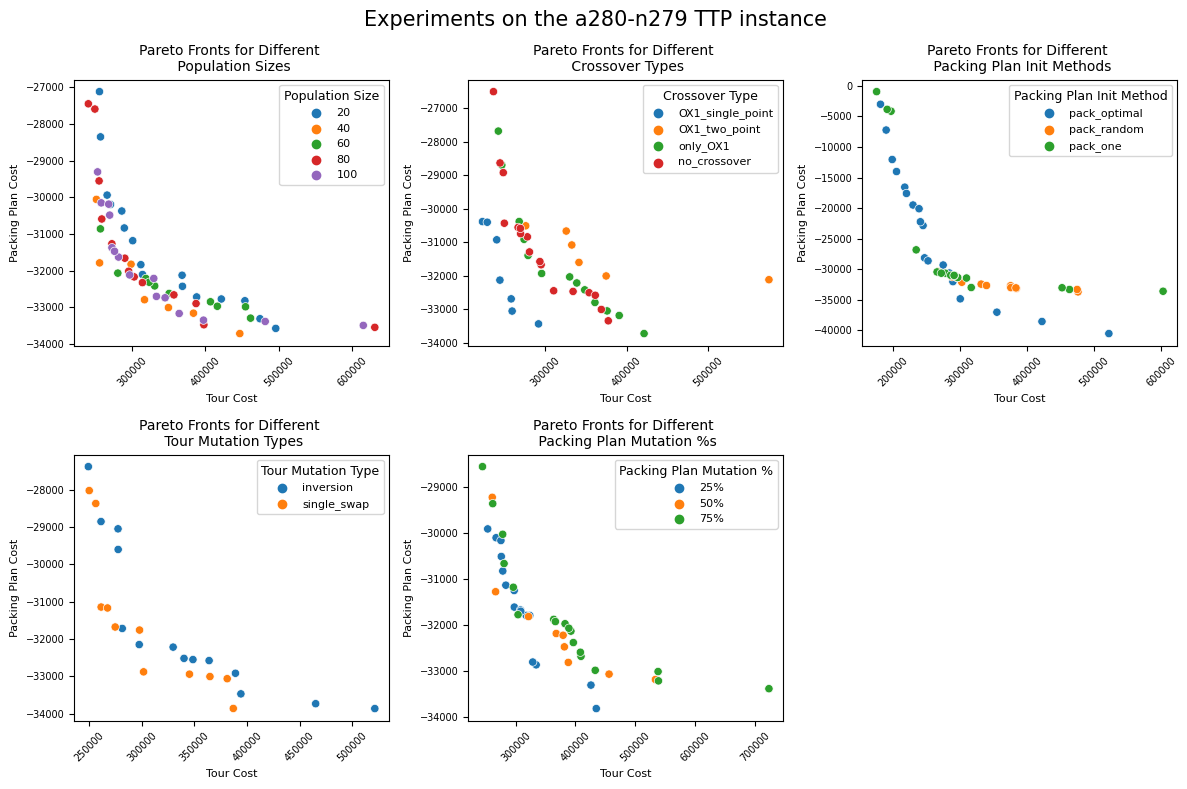

In [185]:
fig, axs = plt.subplots(2, 3, figsize = (12, 8))
sns.scatterplot(x = all_pop_size_exp_pareto["tour_costs"], 
                y = all_pop_size_exp_pareto["packing_plan_costs"] * -1, 
                hue = all_pop_size_exp_pareto["pop_size"], 
                ax = axs[0][0]
                ).set_title("Pareto Fronts for Different \n Population Sizes", fontsize = 10)
axs[0][0].set_xlabel("Tour Cost", fontsize = 8)
axs[0][0].set_ylabel("Packing Plan Cost", fontsize = 8)
axs[0][0].set_xticklabels(axs[0][0].get_xticklabels(), rotation = 45, fontsize = 7)
axs[0][0].set_yticklabels(axs[0][0].get_yticklabels(), fontsize = 7)
axs[0][0].legend(prop=dict(size=8)).set_title(prop = dict(size = 9), title = "Population Size")

sns.scatterplot(x = all_cross_type_exp_pareto["tour_costs"], 
                y = all_cross_type_exp_pareto["packing_plan_costs"] * -1, 
                hue = all_cross_type_exp_pareto["crossover_type"], 
                ax = axs[0][1]
                ).set_title("Pareto Fronts for Different \n Crossover Types", fontsize = 10)
axs[0][1].set_xlabel("Tour Cost", fontsize = 8)
axs[0][1].set_ylabel("Packing Plan Cost", fontsize = 8)
axs[0][1].set_xticklabels(axs[0][1].get_xticklabels(), rotation = 45, fontsize = 7)
axs[0][1].set_yticklabels(axs[0][1].get_yticklabels(), fontsize = 7)
axs[0][1].legend(prop=dict(size=8)).set_title(prop = dict(size = 9), title = "Crossover Type")

sns.scatterplot(x = all_packing_plan_init_method_exp_pareto["tour_costs"], 
                y = all_packing_plan_init_method_exp_pareto["packing_plan_costs"] * -1, 
                hue = all_packing_plan_init_method_exp_pareto["packing_plan_init_method"],
                ax = axs[0][2]
                ).set_title("Pareto Fronts for Different \n Packing Plan Init Methods", fontsize = 10)
axs[0][2].set_xlabel("Tour Cost", fontsize = 8)
axs[0][2].set_ylabel("Packing Plan Cost", fontsize = 8)
axs[0][2].set_xticklabels(axs[0][2].get_xticklabels(), rotation = 45, fontsize = 7)
axs[0][2].set_yticklabels(axs[0][2].get_yticklabels(), fontsize = 7)
axs[0][2].legend(prop=dict(size=8)).set_title(prop = dict(size = 9), title = "Packing Plan Init Method")

sns.scatterplot(x = all_mut_type_exp_pareto["tour_costs"], 
                y = all_mut_type_exp_pareto["packing_plan_costs"] * -1, 
                hue = all_mut_type_exp_pareto["tour_mutation_type"], 
                ax = axs[1][0]
                ).set_title("Pareto Fronts for Different \n Tour Mutation Types", fontsize = 10)
axs[1][0].set_xlabel("Tour Cost", fontsize = 8)
axs[1][0].set_ylabel("Packing Plan Cost", fontsize = 8)
axs[1][0].set_xticklabels(axs[1][0].get_xticklabels(), rotation = 45, fontsize = 7)
axs[1][0].set_yticklabels(axs[1][0].get_yticklabels(), fontsize = 7)
axs[1][0].legend(prop=dict(size=8)).set_title(prop = dict(size = 9), title = "Tour Mutation Type")

sns.scatterplot(x = all_mut_perc_exp_pareto["tour_costs"], 
                y = all_mut_perc_exp_pareto["packing_plan_costs"] * -1, 
                hue = all_mut_perc_exp_pareto["mutation_percentage"], 
                ax = axs[1][1]
                ).set_title("Pareto Fronts for Different \n Packing Plan Mutation %s", fontsize = 10)
axs[1][1].set_xlabel("Tour Cost", fontsize = 8)
axs[1][1].set_ylabel("Packing Plan Cost", fontsize = 8)
axs[1][1].set_xticklabels(axs[1][1].get_xticklabels(), rotation = 45, fontsize = 7)
axs[1][1].set_yticklabels(axs[1][1].get_yticklabels(), fontsize = 7)
axs[1][1].legend(prop=dict(size=8)).set_title(prop = dict(size = 9), title = "Packing Plan Mutation %")

axs[1][2].set_visible(False)

fig.suptitle("Experiments on the a280-n279 TTP instance", fontsize = 15)

plt.tight_layout()
plt.savefig("../figures/a280_n279_experiments.png")

## Pareto Fronts for all instances using the final algorithm (determined from the optimal parameters derived from the above analysis)

### a280_n279 final algorithm

In [186]:
# pop_size = 40
# population = generate_initial_population(pop_size, a280_n279_nb_cities, "pack_optimal", "random", a280_n279_Q, a280_n279_value_to_weight_ratio_dict, a280_n279_item_weights)
# print("initialised")
# for candidate_solution in population:
#     evaluate_candidate_solution_cost_pdist(
#         candidate_solution, 
#         a280_n279_pairwise_distances,
#         a280_n279_item_to_city_mapping_dict, 
#         a280_n279_item_weights,
#         a280_n279_item_values,
#         a280_n279_vmax, 
#         a280_n279_vmin,  
#         a280_n279_Q,
#         a280_n279_R
#     )
# print("evaluated init pop")
# get_ranks(population)
# get_crowding_distance(population)
# for i in range(max_gen):
#     print(i)
#     children = []
#     for _ in range(int(pop_size / 2)):
#         parent1 = tournament_selection(population)
#         parent2 = tournament_selection(population)

#         x = np.random.random(1)

#         if x < 0.5:
#             child1, child2 = OX1_tour_crossover(parent1, parent2)
#         else:
#             child1, child2 = packing_plan_crossover(parent1, parent2, "single_point")
#             child1.tour = derive_tour_from_packing_plan(child1, a280_n279_item_to_city_mapping_dict, a280_n279_item_weights)
#             child2.tour = derive_tour_from_packing_plan(child2, a280_n279_item_to_city_mapping_dict, a280_n279_item_weights)
            

#         child1, child2 = tour_mutation(child1, child2, "single_swap")
#         child1, child2 = packing_plan_mutation(child1, child2, 0.25)
#         repair_packing_plan(child1, a280_n279_Q, a280_n279_item_weights)
#         repair_packing_plan(child2, a280_n279_Q, a280_n279_item_weights)
        
        

#         children.append(child1)
#         children.append(child2)
    
#     for child in children:
#         evaluate_candidate_solution_cost_pdist(
#             child, 
#             a280_n279_pairwise_distances,
#             a280_n279_item_to_city_mapping_dict, 
#             a280_n279_item_weights,
#             a280_n279_item_values,
#             a280_n279_vmax, 
#             a280_n279_vmin,  
#             a280_n279_Q,
#             a280_n279_R
#         )

#     population += children
#     get_ranks(population)
#     get_crowding_distance(population)
#     population = replacement(population, pop_size)

# pd.DataFrame({"tours": [sol.tour for sol in population], 
#             "packing_plans": [sol.packing_plan for sol in population],
#             "tour_costs": [sol.tour_cost for sol in population],
#             "packing_plan_costs": [sol.packing_plan_cost for sol in population],
#             "rank": [sol.rank for sol in population],
#             "crowding_distance": [sol.crowding_distance for sol in population]
#             }).to_csv('../experimental_data/a280_n279_end_populations.csv', sep = ";")

[Text(0.5, 1.0, 'a280_n279 Optimal Algorithm End Population Ranks')]

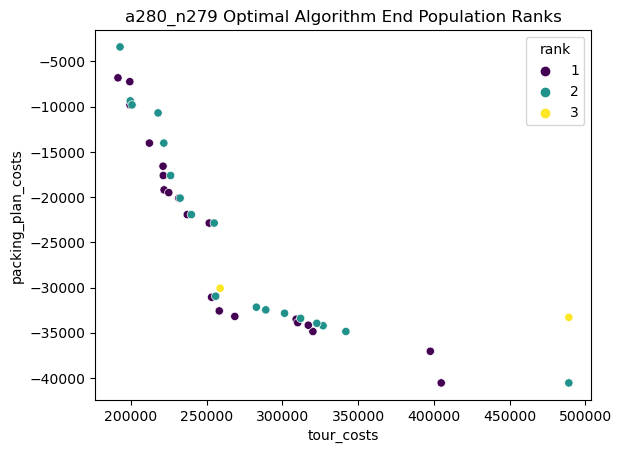

In [187]:
a280_n279_end_populations = pd.read_csv('../experimental_data/a280_n279_end_populations.csv', sep = ";")
sns.scatterplot(x = a280_n279_end_populations["tour_costs"], 
                y = a280_n279_end_populations["packing_plan_costs"] * -1, 
                hue = a280_n279_end_populations["rank"], 
                palette="viridis"
                ).set(title = "a280_n279 Optimal Algorithm End Population Ranks")

C:\Users\hpapa\AppData\Local\Temp\ipykernel_23044\810523313.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize = 7)
C:\Users\hpapa\AppData\Local\Temp\ipykernel_23044\810523313.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize = 7)


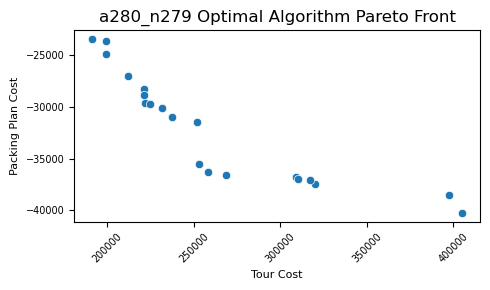

In [188]:
fig, ax = plt.subplots(figsize = (5, 3))
a280_n279_pareto_front = a280_n279_end_populations[a280_n279_end_populations["rank"] == 1]
sns.scatterplot(x = a280_n279_pareto_front["tour_costs"], 
                y = a280_n279_pareto_front["packing_plan_costs"] * -1,
                ax = ax
                ).set(title = "a280_n279 Optimal Algorithm Pareto Front")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize = 7)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 7)
ax.set_xlabel("Tour Cost", fontsize = 8)
ax.set_ylabel("Packing Plan Cost", fontsize = 8)
plt.tight_layout()

### a280_n1395 final algorithm

In [68]:
a280_n1395 = read_TTP_instance_data("../data/a280-n1395.txt")
a280_n1395_nb_cities = a280_n1395["nb_cities"]
a280_n1395_nb_items = a280_n1395["nb_items"]
a280_n1395_Q = a280_n1395["Q"]
a280_n1395_vmin = a280_n1395["v_min"]
a280_n1395_vmax = a280_n1395["v_max"]
a280_n1395_R = a280_n1395["R"]
a280_n1395_pairwise_distances = a280_n1395["pairwise_distances"]
a280_n1395_item_to_city_mapping_dict = a280_n1395["item_to_city_mapping_dict"]
a280_n1395_item_weights = a280_n1395["item_weights"]
a280_n1395_item_values = a280_n1395["item_values"]
a280_n1395_value_to_weight_ratio_dict = a280_n1395["value_to_weight_ratio_dict"]

In [69]:
max_gen = 100

In [70]:
# pop_size = 40
# population = generate_initial_population(pop_size, a280_n1395_nb_cities, "pack_optimal", "random", a280_n1395_Q, a280_n1395_value_to_weight_ratio_dict, a280_n1395_item_weights)
# print("initialised")
# for candidate_solution in population:
#     evaluate_candidate_solution_cost_pdist(
#         candidate_solution, 
#         a280_n1395_pairwise_distances,
#         a280_n1395_item_to_city_mapping_dict, 
#         a280_n1395_item_weights,
#         a280_n1395_item_values,
#         a280_n1395_vmax, 
#         a280_n1395_vmin,  
#         a280_n1395_Q,
#         a280_n1395_R
#     )
# print("evaluated init pop")
# get_ranks(population)
# get_crowding_distance(population)
# for i in range(max_gen):
#     print(i)
#     children = []
#     for _ in range(int(pop_size / 2)):
#         parent1 = tournament_selection(population)
#         parent2 = tournament_selection(population)

#         x = np.random.random(1)

#         if x < 0.5:
#             child1, child2 = OX1_tour_crossover(parent1, parent2)
#         else:
#             child1, child2 = packing_plan_crossover(parent1, parent2, "single_point")
#             child1.tour = derive_tour_from_packing_plan(child1, a280_n1395_item_to_city_mapping_dict, a280_n1395_item_weights)
#             child2.tour = derive_tour_from_packing_plan(child2, a280_n1395_item_to_city_mapping_dict, a280_n1395_item_weights)
            

#         child1, child2 = tour_mutation(child1, child2, "single_swap")
#         child1, child2 = packing_plan_mutation(child1, child2, 0.25)
#         repair_packing_plan(child1, a280_n1395_Q, a280_n1395_item_weights)
#         repair_packing_plan(child2, a280_n1395_Q, a280_n1395_item_weights)
        
        

#         children.append(child1)
#         children.append(child2)
    
#     for child in children:
#         evaluate_candidate_solution_cost_pdist(
#             child, 
#             a280_n1395_pairwise_distances,
#             a280_n1395_item_to_city_mapping_dict, 
#             a280_n1395_item_weights,
#             a280_n1395_item_values,
#             a280_n1395_vmax, 
#             a280_n1395_vmin,  
#             a280_n1395_Q,
#             a280_n1395_R
#         )

#     population += children
#     get_ranks(population)
#     get_crowding_distance(population)
#     population = replacement(population, pop_size)

# pd.DataFrame({"tours": [sol.tour for sol in population], 
#             "packing_plans": [sol.packing_plan for sol in population],
#             "tour_costs": [sol.tour_cost for sol in population],
#             "packing_plan_costs": [sol.packing_plan_cost for sol in population],
#             "rank": [sol.rank for sol in population],
#             "crowding_distance": [sol.crowding_distance for sol in population]
#             }).to_csv('D:/Travelling-Thief-Problem/experimental_data/a280_n1395_end_populations.csv', sep = ";")

[Text(0.5, 1.0, 'a280_n1395 Optimal Algorithm End Population Ranks')]

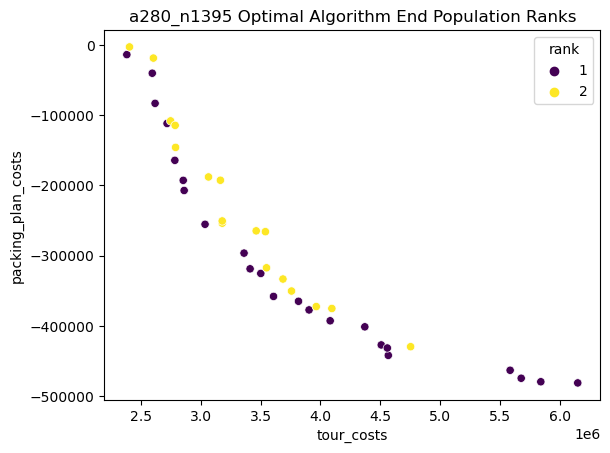

In [189]:
# copy from TTP_solver_with_experiments.ipynb
a280_n1395_CSV = pd.read_csv('../experimental_data/a280_n1395_end_populations.csv',sep = ";")
# a280_n1395_CSV.head()
sns.scatterplot(x = a280_n1395_CSV["tour_costs"], 
                y = a280_n1395_CSV["packing_plan_costs"] * -1, 
                hue = a280_n1395_CSV["rank"], 
                palette="viridis"
                ).set(title = "a280_n1395 Optimal Algorithm End Population Ranks")

## 	a280_n2790 final algorithm

In [72]:
a280_n2790 = read_TTP_instance_data("../data/a280-n2790.txt")
a280_n2790_nb_cities = a280_n2790["nb_cities"]
a280_n2790_nb_items = a280_n2790["nb_items"]
a280_n2790_Q = a280_n2790["Q"]
a280_n2790_vmin = a280_n2790["v_min"]
a280_n2790_vmax = a280_n2790["v_max"]
a280_n2790_R = a280_n2790["R"]
a280_n2790_pairwise_distances = a280_n2790["pairwise_distances"]
a280_n2790_item_to_city_mapping_dict = a280_n2790["item_to_city_mapping_dict"]
a280_n2790_item_weights = a280_n2790["item_weights"]
a280_n2790_item_values = a280_n2790["item_values"]
a280_n2790_value_to_weight_ratio_dict = a280_n2790["value_to_weight_ratio_dict"]

In [73]:
max_gen = 100

In [74]:
# pop_size = 40
# population = generate_initial_population(pop_size, a280_n2790_nb_cities, "pack_optimal", "random", a280_n2790_Q, a280_n2790_value_to_weight_ratio_dict, a280_n2790_item_weights)
# print("initialised")
# for candidate_solution in population:
#     evaluate_candidate_solution_cost_pdist(
#         candidate_solution, 
#         a280_n2790_pairwise_distances,
#         a280_n2790_item_to_city_mapping_dict, 
#         a280_n2790_item_weights,
#         a280_n2790_item_values,
#         a280_n2790_vmax, 
#         a280_n2790_vmin,  
#         a280_n2790_Q,
#         a280_n2790_R
#     )
# print("evaluated init pop")
# get_ranks(population)
# get_crowding_distance(population)
# for i in range(max_gen):
#     print(i)
#     children = []
#     for _ in range(int(pop_size / 2)):
#         parent1 = tournament_selection(population)
#         parent2 = tournament_selection(population)

#         x = np.random.random(1)

#         if x < 0.5:
#             child1, child2 = OX1_tour_crossover(parent1, parent2)
#         else:
#             child1, child2 = packing_plan_crossover(parent1, parent2, "single_point")
#             child1.tour = derive_tour_from_packing_plan(child1, a280_n2790_item_to_city_mapping_dict, a280_n2790_item_weights)
#             child2.tour = derive_tour_from_packing_plan(child2, a280_n2790_item_to_city_mapping_dict, a280_n2790_item_weights)
            

#         child1, child2 = tour_mutation(child1, child2, "single_swap")
#         child1, child2 = packing_plan_mutation(child1, child2, 0.25)
#         repair_packing_plan(child1, a280_n2790_Q, a280_n2790_item_weights)
#         repair_packing_plan(child2, a280_n2790_Q, a280_n2790_item_weights)
        
        

#         children.append(child1)
#         children.append(child2)
    
#     for child in children:
#         evaluate_candidate_solution_cost_pdist(
#             child, 
#             a280_n2790_pairwise_distances,
#             a280_n2790_item_to_city_mapping_dict, 
#             a280_n2790_item_weights,
#             a280_n2790_item_values,
#             a280_n2790_vmax, 
#             a280_n2790_vmin,  
#             a280_n2790_Q,
#             a280_n2790_R
#         )

#     population += children
#     get_ranks(population)
#     get_crowding_distance(population)
#     population = replacement(population, pop_size)

# pd.DataFrame({"tours": [sol.tour for sol in population], 
#             "packing_plans": [sol.packing_plan for sol in population],
#             "tour_costs": [sol.tour_cost for sol in population],
#             "packing_plan_costs": [sol.packing_plan_cost for sol in population],
#             "rank": [sol.rank for sol in population],
#             "crowding_distance": [sol.crowding_distance for sol in population]
#             }).to_csv('../experimental_data/a280_n2790_end_populations.csv', sep = ";")

<Axes: xlabel='tour_costs', ylabel='packing_plan_costs'>

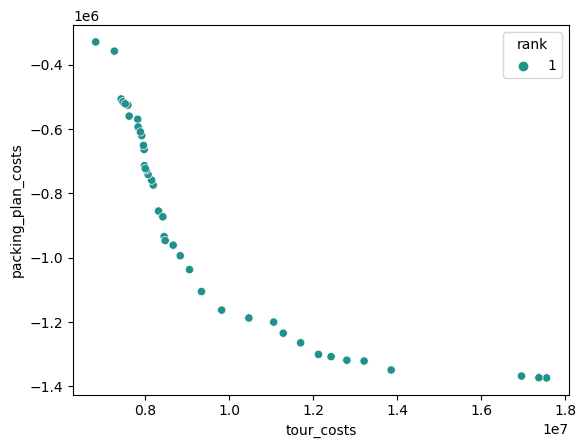

In [190]:
# copy from TTP_solver_with_experiments.ipynb
a280_n2790_CSV = pd.read_csv('../experimental_data/a280_n2790_end_populations.csv',sep = ";")
# a280_n1395_CSV.head()
sns.scatterplot(x = a280_n2790_CSV["tour_costs"], 
                y = a280_n2790_CSV["packing_plan_costs"] * -1, 
                hue = a280_n2790_CSV["rank"], 
                palette="viridis"
                )

### fnl4461_n4460 final algorithm

In [76]:
fnl4461_n4460 = read_TTP_instance_data("../data/fnl4461-n4460.txt")
fnl4461_n4460_nb_cities = fnl4461_n4460["nb_cities"]
fnl4461_n4460_nb_items = fnl4461_n4460["nb_items"]
fnl4461_n4460_Q = fnl4461_n4460["Q"]
fnl4461_n4460_vmin = fnl4461_n4460["v_min"]
fnl4461_n4460_vmax = fnl4461_n4460["v_max"]
fnl4461_n4460_R = fnl4461_n4460["R"]
fnl4461_n4460_pairwise_distances = fnl4461_n4460["pairwise_distances"]
fnl4461_n4460_item_to_city_mapping_dict = fnl4461_n4460["item_to_city_mapping_dict"]
fnl4461_n4460_item_weights = fnl4461_n4460["item_weights"]
fnl4461_n4460_item_values = fnl4461_n4460["item_values"]
fnl4461_n4460_value_to_weight_ratio_dict = fnl4461_n4460["value_to_weight_ratio_dict"]

In [77]:
max_gen = 100

In [78]:
# pop_size = 40
# population = generate_initial_population(pop_size, fnl4461_n4460_nb_cities, "pack_optimal", "random", fnl4461_n4460_Q, fnl4461_n4460_value_to_weight_ratio_dict, fnl4461_n4460_item_weights)
# print("initialised")
# for candidate_solution in population:
#     evaluate_candidate_solution_cost_pdist(
#         candidate_solution, 
#         fnl4461_n4460_pairwise_distances,
#         fnl4461_n4460_item_to_city_mapping_dict, 
#         fnl4461_n4460_item_weights,
#         fnl4461_n4460_item_values,
#         fnl4461_n4460_vmax, 
#         fnl4461_n4460_vmin,  
#         fnl4461_n4460_Q,
#         fnl4461_n4460_R
#     )
# print("evaluated init pop")
# get_ranks(population)
# get_crowding_distance(population)
# for i in range(max_gen):
#     print(i)
#     children = []
#     for _ in range(int(pop_size / 2)):
#         parent1 = tournament_selection(population)
#         parent2 = tournament_selection(population)

#         x = np.random.random(1)

#         if x < 0.5:
#             child1, child2 = OX1_tour_crossover(parent1, parent2)
#         else:
#             child1, child2 = packing_plan_crossover(parent1, parent2, "single_point")
#             child1.tour = derive_tour_from_packing_plan(child1, fnl4461_n4460_item_to_city_mapping_dict, fnl4461_n4460_item_weights)
#             child2.tour = derive_tour_from_packing_plan(child2, fnl4461_n4460_item_to_city_mapping_dict, fnl4461_n4460_item_weights)
            

#         child1, child2 = tour_mutation(child1, child2, "single_swap")
#         child1, child2 = packing_plan_mutation(child1, child2, 0.25)
#         repair_packing_plan(child1, fnl4461_n4460_Q, fnl4461_n4460_item_weights)
#         repair_packing_plan(child2, fnl4461_n4460_Q, fnl4461_n4460_item_weights)
        
        

#         children.append(child1)
#         children.append(child2)
    
#     for child in children:
#         evaluate_candidate_solution_cost_pdist(
#             child, 
#             fnl4461_n4460_pairwise_distances,
#             fnl4461_n4460_item_to_city_mapping_dict, 
#             fnl4461_n4460_item_weights,
#             fnl4461_n4460_item_values,
#             fnl4461_n4460_vmax, 
#             fnl4461_n4460_vmin,  
#             fnl4461_n4460_Q,
#             fnl4461_n4460_R
#         )

#     population += children
#     get_ranks(population)
#     get_crowding_distance(population)
#     population = replacement(population, pop_size)

# pd.DataFrame({"tours": [sol.tour for sol in population], 
#             "packing_plans": [sol.packing_plan for sol in population],
#             "tour_costs": [sol.tour_cost for sol in population],
#             "packing_plan_costs": [sol.packing_plan_cost for sol in population],
#             "rank": [sol.rank for sol in population],
#             "crowding_distance": [sol.crowding_distance for sol in population]
#             }).to_csv('../experimental_data/fnl4461_n4460_end_pop_size_20.csv', sep = ";")

<Axes: xlabel='tour_costs', ylabel='packing_plan_costs'>

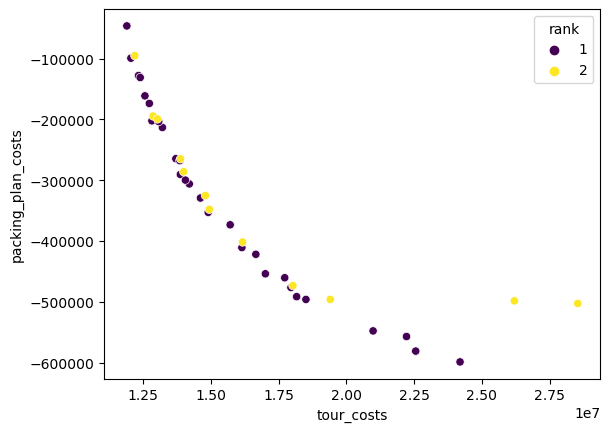

In [191]:
# copy from TTP_solver_with_experiments.ipynb
fnl4461_n4460_CSV = pd.read_csv('../experimental_data/fnl4461_n4460_end_pop_size_40_new.csv',sep = ";")
# fnl4461_n4460_CSV.head()
sns.scatterplot(x = fnl4461_n4460_CSV["tour_costs"], 
                y = fnl4461_n4460_CSV["packing_plan_costs"] * -1, 
                hue = fnl4461_n4460_CSV["rank"], 
                palette="viridis"
                )

### fnl4461_n22300 final algorithm

In [80]:
fnl4461_n22300 = read_TTP_instance_data("../data/fnl4461-n22300.txt")
fnl4461_n22300_nb_cities = fnl4461_n22300["nb_cities"]
fnl4461_n22300_nb_items = fnl4461_n22300["nb_items"]
fnl4461_n22300_Q = fnl4461_n22300["Q"]
fnl4461_n22300_vmin = fnl4461_n22300["v_min"]
fnl4461_n22300_vmax = fnl4461_n22300["v_max"]
fnl4461_n22300_R = fnl4461_n22300["R"]
fnl4461_n22300_pairwise_distances = fnl4461_n22300["pairwise_distances"]
fnl4461_n22300_item_to_city_mapping_dict = fnl4461_n22300["item_to_city_mapping_dict"]
fnl4461_n22300_item_weights = fnl4461_n22300["item_weights"]
fnl4461_n22300_item_values = fnl4461_n22300["item_values"]
fnl4461_n22300_value_to_weight_ratio_dict = fnl4461_n22300["value_to_weight_ratio_dict"]

In [81]:
max_gen = 100

In [82]:
# pop_size = 40
# population = generate_initial_population(pop_size, fnl4461_n22300_nb_cities, "pack_optimal", "random", fnl4461_n22300_Q, fnl4461_n22300_value_to_weight_ratio_dict, fnl4461_n22300_item_weights)
# print("initialised")
# for candidate_solution in population:
#     evaluate_candidate_solution_cost_pdist(
#         candidate_solution, 
#         fnl4461_n22300_pairwise_distances,
#         fnl4461_n22300_item_to_city_mapping_dict, 
#         fnl4461_n22300_item_weights,
#         fnl4461_n22300_item_values,
#         fnl4461_n22300_vmax, 
#         fnl4461_n22300_vmin,  
#         fnl4461_n22300_Q,
#         fnl4461_n22300_R
#     )
# print("evaluated init pop")
# get_ranks(population)
# get_crowding_distance(population)
# for i in range(max_gen):
#     print(i)
#     children = []
#     for _ in range(int(pop_size / 2)):
#         parent1 = tournament_selection(population)
#         parent2 = tournament_selection(population)

#         x = np.random.random(1)

#         if x < 0.5:
#             child1, child2 = OX1_tour_crossover(parent1, parent2)
#         else:
#             child1, child2 = packing_plan_crossover(parent1, parent2, "single_point")
#             child1.tour = derive_tour_from_packing_plan(child1, fnl4461_n22300_item_to_city_mapping_dict, fnl4461_n22300_item_weights)
#             child2.tour = derive_tour_from_packing_plan(child2, fnl4461_n22300_item_to_city_mapping_dict, fnl4461_n22300_item_weights)
            

#         child1, child2 = tour_mutation(child1, child2, "single_swap")
#         child1, child2 = packing_plan_mutation(child1, child2, 0.25)
#         repair_packing_plan(child1, fnl4461_n22300_Q, fnl4461_n22300_item_weights)
#         repair_packing_plan(child2, fnl4461_n22300_Q, fnl4461_n22300_item_weights)
        
        

#         children.append(child1)
#         children.append(child2)
    
#     for child in children:
#         evaluate_candidate_solution_cost_pdist(
#             child, 
#             fnl4461_n22300_pairwise_distances,
#             fnl4461_n22300_item_to_city_mapping_dict, 
#             fnl4461_n22300_item_weights,
#             fnl4461_n22300_item_values,
#             fnl4461_n22300_vmax, 
#             fnl4461_n22300_vmin,  
#             fnl4461_n22300_Q,
#             fnl4461_n22300_R
#         )

#     population += children
#     get_ranks(population)
#     get_crowding_distance(population)
#     population = replacement(population, pop_size)

# pd.DataFrame({"tours": [sol.tour for sol in population], 
#             "packing_plans": [sol.packing_plan for sol in population],
#             "tour_costs": [sol.tour_cost for sol in population],
#             "packing_plan_costs": [sol.packing_plan_cost for sol in population],
#             "rank": [sol.rank for sol in population],
#             "crowding_distance": [sol.crowding_distance for sol in population]
#             }).to_csv('../experimental_data/np_fnl4461_n22300_end_populations.csv', sep = ";")

<Axes: xlabel='tour_costs', ylabel='packing_plan_costs'>

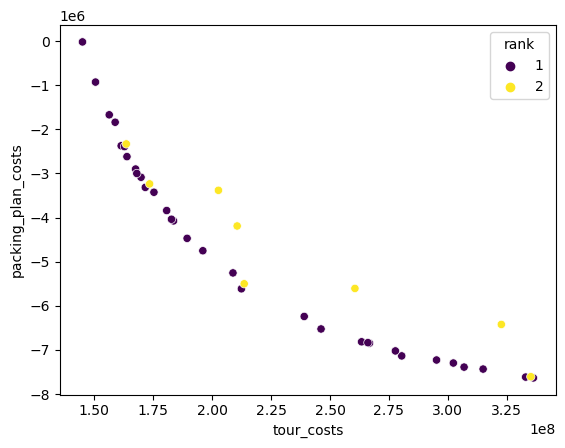

In [192]:
# copy from TTP_solver_with_experiments.ipynb
fnl4461_n22300_CSV = pd.read_csv('../experimental_data/np_fnl4461_n22300_end_populations.csv',sep = ";")
# fnl4461_n22300_CSV.head()
sns.scatterplot(x = fnl4461_n22300_CSV["tour_costs"], 
                y = fnl4461_n22300_CSV["packing_plan_costs"] * -1, 
                hue = fnl4461_n22300_CSV["rank"], 
                palette="viridis"
                )

### fnl4461_n44600 final algorithm

In [84]:
fnl4461_n44600 = read_TTP_instance_data("../data/fnl4461-n44600.txt")
fnl4461_n44600_nb_cities = fnl4461_n44600["nb_cities"]
fnl4461_n44600_nb_items = fnl4461_n44600["nb_items"]
fnl4461_n44600_Q = fnl4461_n44600["Q"]
fnl4461_n44600_vmin = fnl4461_n44600["v_min"]
fnl4461_n44600_vmax = fnl4461_n44600["v_max"]
fnl4461_n44600_R = fnl4461_n44600["R"]
fnl4461_n44600_pairwise_distances = fnl4461_n44600["pairwise_distances"]
fnl4461_n44600_item_to_city_mapping_dict = fnl4461_n44600["item_to_city_mapping_dict"]
fnl4461_n44600_item_weights = fnl4461_n44600["item_weights"]
fnl4461_n44600_item_values = fnl4461_n44600["item_values"]
fnl4461_n44600_value_to_weight_ratio_dict = fnl4461_n44600["value_to_weight_ratio_dict"]

In [85]:
max_gen = 100

In [86]:
# pop_size = 40
# population = generate_initial_population(pop_size, fnl4461_n44600_nb_cities, "pack_optimal", "random", fnl4461_n44600_Q, fnl4461_n44600_value_to_weight_ratio_dict, fnl4461_n44600_item_weights)
# print("initialised")
# for candidate_solution in population:
#     evaluate_candidate_solution_cost_pdist(
#         candidate_solution, 
#         fnl4461_n44600_pairwise_distances,
#         fnl4461_n44600_item_to_city_mapping_dict, 
#         fnl4461_n44600_item_weights,
#         fnl4461_n44600_item_values,
#         fnl4461_n44600_vmax, 
#         fnl4461_n44600_vmin,  
#         fnl4461_n44600_Q,
#         fnl4461_n44600_R
#     )
# print("evaluated init pop")
# get_ranks(population)
# get_crowding_distance(population)
# for i in range(max_gen):
#     print(i)
#     children = []
#     for _ in range(int(pop_size / 2)):
#         parent1 = tournament_selection(population)
#         parent2 = tournament_selection(population)

#         x = np.random.random(1)

#         if x < 0.5:
#             child1, child2 = OX1_tour_crossover(parent1, parent2)
#         else:
#             child1, child2 = packing_plan_crossover(parent1, parent2, "single_point")
#             child1.tour = derive_tour_from_packing_plan(child1, fnl4461_n44600_item_to_city_mapping_dict, fnl4461_n44600_item_weights)
#             child2.tour = derive_tour_from_packing_plan(child2, fnl4461_n44600_item_to_city_mapping_dict, fnl4461_n44600_item_weights)
            

#         child1, child2 = tour_mutation(child1, child2, "single_swap")
#         child1, child2 = packing_plan_mutation(child1, child2, 0.25)
#         repair_packing_plan(child1, fnl4461_n44600_Q, fnl4461_n44600_item_weights)
#         repair_packing_plan(child2, fnl4461_n44600_Q, fnl4461_n44600_item_weights)
        
        

#         children.append(child1)
#         children.append(child2)
    
#     for child in children:
#         evaluate_candidate_solution_cost_pdist(
#             child, 
#             fnl4461_n44600_pairwise_distances,
#             fnl4461_n44600_item_to_city_mapping_dict, 
#             fnl4461_n44600_item_weights,
#             fnl4461_n44600_item_values,
#             fnl4461_n44600_vmax, 
#             fnl4461_n44600_vmin,  
#             fnl4461_n44600_Q,
#             fnl4461_n44600_R
#         )

#     population += children
#     get_ranks(population)
#     get_crowding_distance(population)
#     population = replacement(population, pop_size)

# pd.DataFrame({"tours": [sol.tour for sol in population], 
#             "packing_plans": [sol.packing_plan for sol in population],
#             "tour_costs": [sol.tour_cost for sol in population],
#             "packing_plan_costs": [sol.packing_plan_cost for sol in population],
#             "rank": [sol.rank for sol in population],
#             "crowding_distance": [sol.crowding_distance for sol in population]
#             }).to_csv('../experimental_data/fnl4461_n44600_end_populations.csv', sep = ";")

<Axes: xlabel='tour_costs', ylabel='packing_plan_costs'>

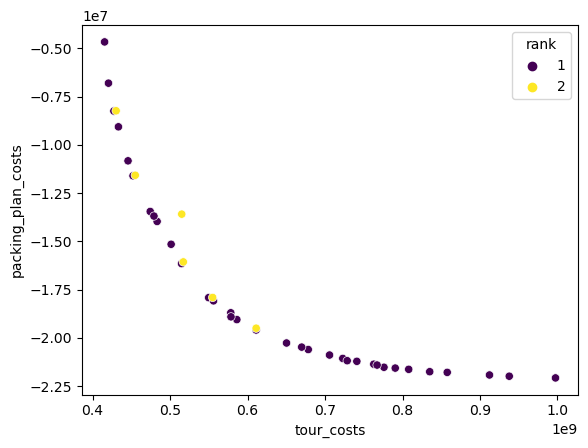

In [193]:
fnl4461_n44600_end_populations = pd.read_csv('../experimental_data/fnl4461_n44600_end_populations.csv', sep = ";")
sns.scatterplot(x = fnl4461_n44600_end_populations["tour_costs"], 
                y = fnl4461_n44600_end_populations["packing_plan_costs"] * -1, 
                hue = fnl4461_n44600_end_populations["rank"], 
                palette="viridis"
                )

### pla33810_n33809 final algorithm

In [88]:
pla33810_n33809 = read_TTP_instance_data("../data/pla33810-n33809.txt")
pla33810_n33809_nb_cities = pla33810_n33809["nb_cities"]
pla33810_n33809_nb_items = pla33810_n33809["nb_items"]
pla33810_n33809_Q = pla33810_n33809["Q"]
pla33810_n33809_vmin = pla33810_n33809["v_min"]
pla33810_n33809_vmax = pla33810_n33809["v_max"]
pla33810_n33809_R = pla33810_n33809["R"]
pla33810_n33809_pairwise_distances = pla33810_n33809["pairwise_distances"]
pla33810_n33809_item_to_city_mapping_dict = pla33810_n33809["item_to_city_mapping_dict"]
pla33810_n33809_item_weights = pla33810_n33809["item_weights"]
pla33810_n33809_item_values = pla33810_n33809["item_values"]
pla33810_n33809_value_to_weight_ratio_dict = pla33810_n33809["value_to_weight_ratio_dict"]

In [89]:
max_gen = 100

In [90]:
# pop_size = 40


# population = generate_initial_population(pop_size, pla33810_n33809_nb_cities, "pack_optimal", "random", pla33810_n33809_Q, pla33810_n33809_value_to_weight_ratio_dict, pla33810_n33809_item_weights)
# for candidate_solution in population:
#     evaluate_candidate_solution_cost_pdist(
#         candidate_solution, 
#         pla33810_n33809_pairwise_distances,
#         pla33810_n33809_item_to_city_mapping_dict, 
#         pla33810_n33809_item_weights,
#         pla33810_n33809_item_values,
#         pla33810_n33809_vmax, 
#         pla33810_n33809_vmin,  
#         pla33810_n33809_Q,
#         pla33810_n33809_R
#     )
# get_ranks(population)
# get_crowding_distance(population)
# for i in range(max_gen):
#     print(i)
#     children = []
#     for _ in range(int(pop_size / 2)):
#         parent1 = tournament_selection(population)
#         parent2 = tournament_selection(population)

#         x = np.random.random(1)

#         if x < 0.5:
#             child1, child2 = OX1_tour_crossover(parent1, parent2)
#         else:
#             child1, child2 = packing_plan_crossover(parent1, parent2, "single_point")
#             child1.tour = derive_tour_from_packing_plan(child1, pla33810_n33809_item_to_city_mapping_dict, pla33810_n33809_item_weights)
#             child2.tour = derive_tour_from_packing_plan(child2, pla33810_n33809_item_to_city_mapping_dict, pla33810_n33809_item_weights)
            

#         child1, child2 = tour_mutation(child1, child2, "single_swap")
#         child1, child2 = packing_plan_mutation(child1, child2, 0.25)
#         repair_packing_plan(child1, pla33810_n33809_Q, pla33810_n33809_item_weights)
#         repair_packing_plan(child2, pla33810_n33809_Q, pla33810_n33809_item_weights)
        
        

#         children.append(child1)
#         children.append(child2)
    

#     for child in children:
#         evaluate_candidate_solution_cost_pdist(
#             child, 
#             pla33810_n33809_pairwise_distances,
#             pla33810_n33809_item_to_city_mapping_dict, 
#             pla33810_n33809_item_weights,
#             pla33810_n33809_item_values,
#             pla33810_n33809_vmax, 
#             pla33810_n33809_vmin,  
#             pla33810_n33809_Q,
#             pla33810_n33809_R
#         )

#     population += children
#     get_ranks(population)
#     get_crowding_distance(population)
#     population = replacement(population, pop_size)

# pd.DataFrame({"tours": [sol.tour for sol in population], 
#             "packing_plans": [sol.packing_plan for sol in population],
#             "tour_costs": [sol.tour_cost for sol in population],
#             "packing_plan_costs": [sol.packing_plan_cost for sol in population],
#             "rank": [sol.rank for sol in population],
#             "crowding_distance": [sol.crowding_distance for sol in population]
#             }).to_csv(f'../experimental_data/pla33810_n33809_final_algo.csv', sep = ";")

<Axes: xlabel='tour_costs', ylabel='packing_plan_costs'>

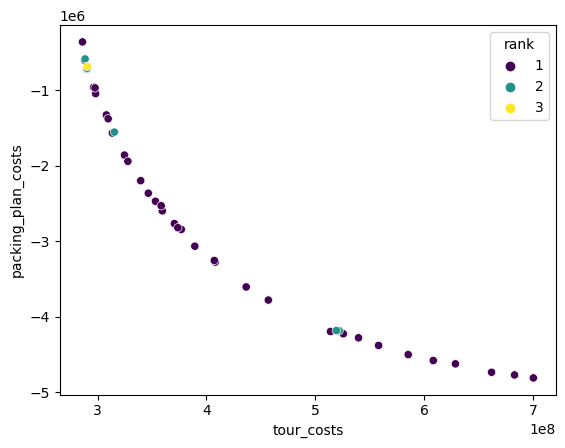

In [194]:
pla33810_n33809_final_algo_20_gens = pd.read_csv('../experimental_data/pla33810_n33809_final_algo_20_gens.csv', sep = ";")
sns.scatterplot(x = pla33810_n33809_final_algo_20_gens["tour_costs"], 
                y = pla33810_n33809_final_algo_20_gens["packing_plan_costs"] * -1, 
                hue = pla33810_n33809_final_algo_20_gens["rank"], 
                palette="viridis"
                )

### pla33810_n169045 final algorithm

In [92]:
pla33810_n169045 = read_TTP_instance_data("../data/pla33810-n33809.txt")
pla33810_n169045_nb_cities = pla33810_n169045["nb_cities"]
pla33810_n169045_nb_items = pla33810_n169045["nb_items"]
pla33810_n169045_Q = pla33810_n169045["Q"]
pla33810_n169045_vmin = pla33810_n169045["v_min"]
pla33810_n169045_vmax = pla33810_n169045["v_max"]
pla33810_n169045_R = pla33810_n169045["R"]
pla33810_n169045_pairwise_distances = pla33810_n169045["pairwise_distances"]
pla33810_n169045_item_to_city_mapping_dict = pla33810_n169045["item_to_city_mapping_dict"]
pla33810_n169045_item_weights = pla33810_n169045["item_weights"]
pla33810_n169045_item_values = pla33810_n169045["item_values"]
pla33810_n169045_value_to_weight_ratio_dict = pla33810_n169045["value_to_weight_ratio_dict"]

In [93]:
max_gen = 100

In [94]:
# pop_size = 40


# population = generate_initial_population(pop_size, pla33810_n169045_nb_cities, "pack_optimal", "random", pla33810_n169045_Q, pla33810_n169045_value_to_weight_ratio_dict, pla33810_n169045_item_weights)
# for candidate_solution in population:
#     evaluate_candidate_solution_cost_pdist(
#         candidate_solution, 
#         pla33810_n169045_pairwise_distances,
#         pla33810_n169045_item_to_city_mapping_dict, 
#         pla33810_n169045_item_weights,
#         pla33810_n169045_item_values,
#         pla33810_n169045_vmax, 
#         pla33810_n169045_vmin,  
#         pla33810_n169045_Q,
#         pla33810_n169045_R
#     )
# get_ranks(population)
# get_crowding_distance(population)
# for i in range(max_gen):
#     print(i)
#     children = []
#     for _ in range(int(pop_size / 2)):
#         parent1 = tournament_selection(population)
#         parent2 = tournament_selection(population)

#         x = np.random.random(1)

#         if x < 0.5:
#             child1, child2 = OX1_tour_crossover(parent1, parent2)
#         else:
#             child1, child2 = packing_plan_crossover(parent1, parent2, "single_point")
#             child1.tour = derive_tour_from_packing_plan(child1, pla33810_n169045_item_to_city_mapping_dict, pla33810_n169045_item_weights)
#             child2.tour = derive_tour_from_packing_plan(child2, pla33810_n169045_item_to_city_mapping_dict, pla33810_n169045_item_weights)
            

#         child1, child2 = tour_mutation(child1, child2, "single_swap")
#         child1, child2 = packing_plan_mutation(child1, child2, 0.25)
#         repair_packing_plan(child1, pla33810_n169045_Q, pla33810_n169045_item_weights)
#         repair_packing_plan(child2, pla33810_n169045_Q, pla33810_n169045_item_weights)
        
        

#         children.append(child1)
#         children.append(child2)
    

#     for child in children:
#         evaluate_candidate_solution_cost_pdist(
#             child, 
#             pla33810_n169045_pairwise_distances,
#             pla33810_n169045_item_to_city_mapping_dict, 
#             pla33810_n169045_item_weights,
#             pla33810_n169045_item_values,
#             pla33810_n169045_vmax, 
#             pla33810_n169045_vmin,  
#             pla33810_n169045_Q,
#             pla33810_n169045_R
#         )

#     population += children
#     get_ranks(population)
#     get_crowding_distance(population)
#     population = replacement(population, pop_size)

# pd.DataFrame({"tours": [sol.tour for sol in population], 
#             "packing_plans": [sol.packing_plan for sol in population],
#             "tour_costs": [sol.tour_cost for sol in population],
#             "packing_plan_costs": [sol.packing_plan_cost for sol in population],
#             "rank": [sol.rank for sol in population],
#             "crowding_distance": [sol.crowding_distance for sol in population]
#             }).to_csv(f'../experimental_data/pla33810_n169045_final_algo.csv', sep = ";")

<Axes: xlabel='tour_costs', ylabel='packing_plan_costs'>

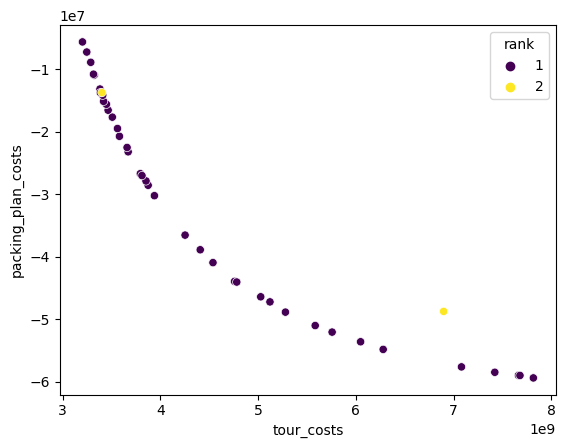

In [195]:
pla33810_n169045_final_algo_20_gens = pd.read_csv('../experimental_data/pla33810_n169045_final_algo.csv', sep = ";")
sns.scatterplot(x = pla33810_n169045_final_algo_20_gens["tour_costs"], 
                y = pla33810_n169045_final_algo_20_gens["packing_plan_costs"] * -1, 
                hue = pla33810_n169045_final_algo_20_gens["rank"], 
                palette="viridis"
                )

### pla33810_n338090 final algorithm

In [96]:
pla33810_n338090 = read_TTP_instance_data("../data/pla33810-n338090.txt")
pla33810_n338090_nb_cities = pla33810_n338090["nb_cities"]
pla33810_n338090_nb_items = pla33810_n338090["nb_items"]
pla33810_n338090_Q = pla33810_n338090["Q"]
pla33810_n338090_vmin = pla33810_n338090["v_min"]
pla33810_n338090_vmax = pla33810_n338090["v_max"]
pla33810_n338090_R = pla33810_n338090["R"]
pla33810_n338090_pairwise_distances = pla33810_n338090["pairwise_distances"]
pla33810_n338090_item_to_city_mapping_dict = pla33810_n338090["item_to_city_mapping_dict"]
pla33810_n338090_item_weights = pla33810_n338090["item_weights"]
pla33810_n338090_item_values = pla33810_n338090["item_values"]
pla33810_n338090_value_to_weight_ratio_dict = pla33810_n338090["value_to_weight_ratio_dict"]

In [97]:
max_gen = 100

In [98]:
# pop_size = 40


# population = generate_initial_population(pop_size, pla33810_n338090_nb_cities, "pack_optimal", "random", pla33810_n338090_Q, pla33810_n338090_value_to_weight_ratio_dict, pla33810_n338090_item_weights)
# for candidate_solution in population:
#     evaluate_candidate_solution_cost_pdist(
#         candidate_solution, 
#         pla33810_n338090_pairwise_distances,
#         pla33810_n338090_item_to_city_mapping_dict, 
#         pla33810_n338090_item_weights,
#         pla33810_n338090_item_values,
#         pla33810_n338090_vmax, 
#         pla33810_n338090_vmin,  
#         pla33810_n338090_Q,
#         pla33810_n338090_R
#     )
# get_ranks(population)
# get_crowding_distance(population)
# for i in range(max_gen):
#     print(i)
#     children = []
#     for _ in range(int(pop_size / 2)):
#         parent1 = tournament_selection(population)
#         parent2 = tournament_selection(population)

#         x = np.random.random(1)

#         if x < 0.5:
#             child1, child2 = OX1_tour_crossover(parent1, parent2)
#         else:
#             child1, child2 = packing_plan_crossover(parent1, parent2, "single_point")
#             child1.tour = derive_tour_from_packing_plan(child1, pla33810_n338090_item_to_city_mapping_dict, pla33810_n338090_item_weights)
#             child2.tour = derive_tour_from_packing_plan(child2, pla33810_n338090_item_to_city_mapping_dict, pla33810_n338090_item_weights)
            

#         child1, child2 = tour_mutation(child1, child2, "single_swap")
#         child1, child2 = packing_plan_mutation(child1, child2, 0.25)
#         repair_packing_plan(child1, pla33810_n338090_Q, pla33810_n338090_item_weights)
#         repair_packing_plan(child2, pla33810_n338090_Q, pla33810_n338090_item_weights)
        
        

#         children.append(child1)
#         children.append(child2)
    

#     for child in children:
#         evaluate_candidate_solution_cost_pdist(
#             child, 
#             pla33810_n338090_pairwise_distances,
#             pla33810_n338090_item_to_city_mapping_dict, 
#             pla33810_n338090_item_weights,
#             pla33810_n338090_item_values,
#             pla33810_n338090_vmax, 
#             pla33810_n338090_vmin,  
#             pla33810_n338090_Q,
#             pla33810_n338090_R
#         )

#     population += children
#     get_ranks(population)
#     get_crowding_distance(population)
#     population = replacement(population, pop_size)

# pd.DataFrame({"tours": [sol.tour for sol in population], 
#             "packing_plans": [sol.packing_plan for sol in population],
#             "tour_costs": [sol.tour_cost for sol in population],
#             "packing_plan_costs": [sol.packing_plan_cost for sol in population],
#             "rank": [sol.rank for sol in population],
#             "crowding_distance": [sol.crowding_distance for sol in population]
#             }).to_csv(f'../experimental_data/pla33810_n338090_final_algo.csv', sep = ";")

<Axes: xlabel='tour_costs', ylabel='packing_plan_costs'>

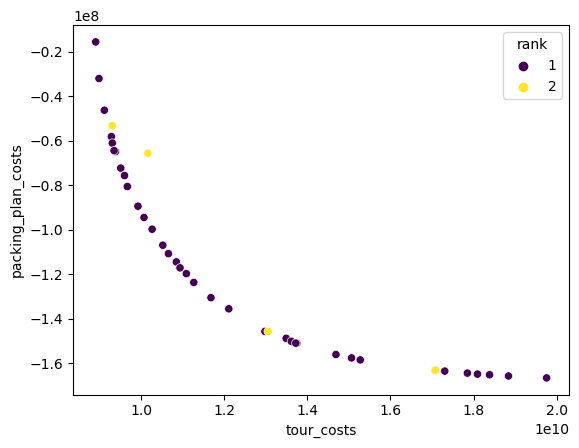

In [196]:
pla33810_n338090_final_algo_20_gens = pd.read_csv('../experimental_data/pla33810_n338090_final_algo.csv', sep = ";")
sns.scatterplot(x = pla33810_n338090_final_algo_20_gens["tour_costs"], 
                y = pla33810_n338090_final_algo_20_gens["packing_plan_costs"] * -1, 
                hue = pla33810_n338090_final_algo_20_gens["rank"], 
                palette="viridis"
                )

### Plotting all the Pareto Fronts

In [75]:
def format_xticks(value, _):
    if value >= 10**5 and value < 10**6:
        return f"{value/10**5:.1f} $\\times 10^5$"
    elif value >= 10**6 and value < 10**7:
        return f"{value/10**6:.1f} $\\times 10^6$"
    elif value >= 10**7 and value < 10**8:
        return f"{value/10**7:.1f} $\\times 10^7$"
    elif value >= 10**8 and value < 10**9:
        return f"{value/10**8:.1f} $\\times 10^8$"
    elif value >= 10**9 and value < 10**10:
        return f"{value/10**9:.1f} $\\times 10^9$"
    elif value >= 10**10 and value < 10**11:
        return f"{value/10**10:.1f} $\\times 10^{{10}}$"
    else:
        return f"{value:.000f}"
    
def format_yticks(value, _):
    if value <= -10**4 and value > -10**5:
        return f"{value/10**4:.1f} $\\times 10^4$"
    elif value <= -10**5 and value > -10**6:
        return f"{value/10**5:.1f} $\\times 10^5$"
    elif value <= -10**6 and value > -10**7:
        return f"{value/10**6:.1f} $\\times 10^6$"
    elif value <= -10**7 and value > -10**8:
        return f"{value/10**7:.1f} $\\times 10^7$"
    elif value <= -10**8 and value > -10**9:
        return f"{value/10**8:.1f} $\\times 10^8$"
    elif value <= -10**9 and value > -10**10:
        return f"{value/10**9:.1f} $\\times 10^9$"
    else:
        return f"{-value:.2}"

C:\Users\hpapa\AppData\Local\Temp\ipykernel_23044\3593353296.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0][0].set_xticklabels(axs[0][0].get_xticklabels(), rotation=45, fontsize = 8.5)
C:\Users\hpapa\AppData\Local\Temp\ipykernel_23044\3593353296.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0][0].set_yticklabels(axs[0][0].get_yticklabels(), fontsize = 8.5)
C:\Users\hpapa\AppData\Local\Temp\ipykernel_23044\3593353296.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0][1].set_xticklabels(axs[0][1].get_xticklabels(), rotation=45, fontsize = 8.5)
C:\Users\hpapa\AppData\Local\Temp\ipykernel_23044\3593353296.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0][1].set_yticklabels(axs[0][1].get_yticklabels(), fontsize = 8.5)
C:\Users\hpapa\AppData\Local\Temp\ipykernel_23044\3593353296.py:38: UserWarning: FixedFormatter should only be 

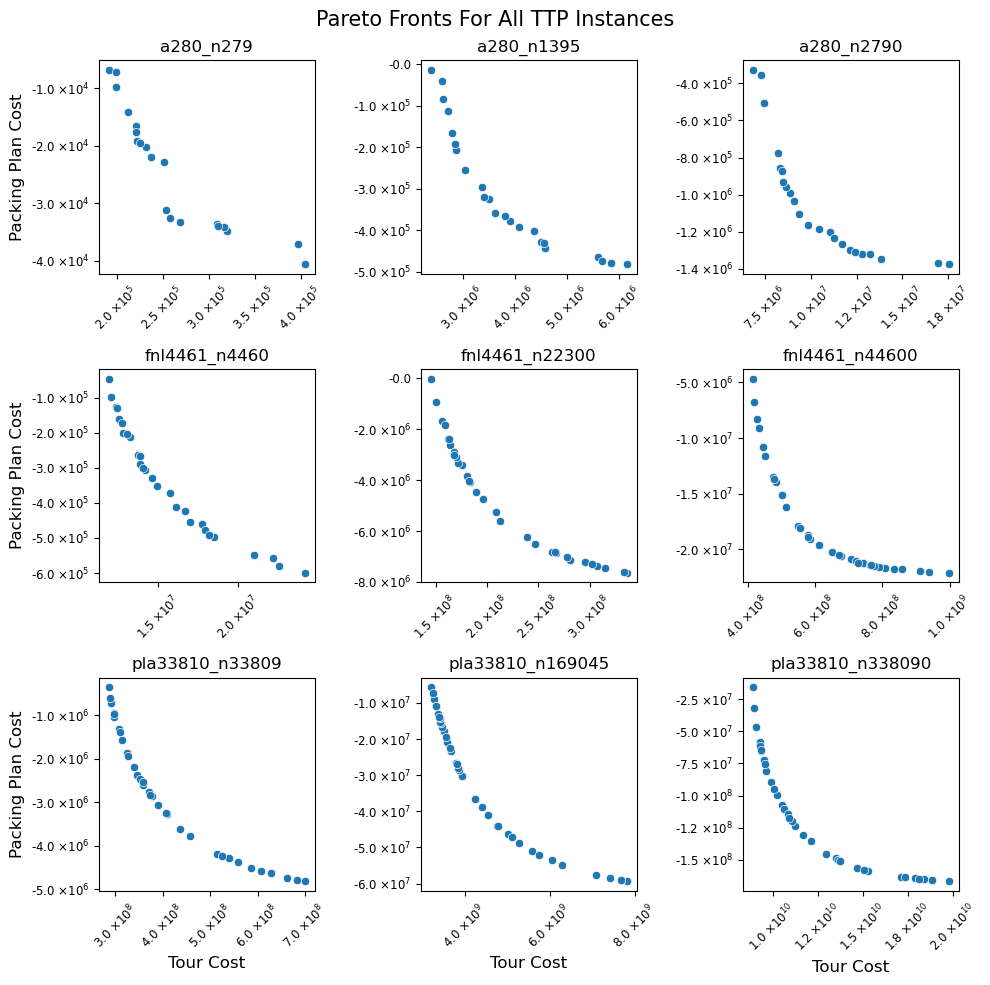

In [76]:
fig, axs = plt.subplots(3, 3, figsize = (10, 10))

# a280_n279
a280_n279_pareto_front = a280_n279_end_populations[a280_n279_end_populations["rank"] == 1]
sns.scatterplot(x = a280_n279_pareto_front["tour_costs"], 
                y = a280_n279_pareto_front["packing_plan_costs"] * -1,
                ax = axs[0][0]
                ).set(title = "a280_n279")
axs[0][0].set_xticklabels(axs[0][0].get_xticklabels(), rotation=45, fontsize = 8.5)
axs[0][0].set_yticklabels(axs[0][0].get_yticklabels(), fontsize = 8.5)
# axs[0][0].set_xlabel("Tour Cost", fontsize = 10)
axs[0][0].set_ylabel("Packing Plan Cost", fontsize = 12)
axs[0][0].xaxis.set_major_formatter(FuncFormatter(format_xticks))
axs[0][0].set(xlabel = None)
axs[0][0].yaxis.set_major_formatter(FuncFormatter(format_yticks))

# a280_n1395
a280_n1395_pareto_front = a280_n1395_CSV[a280_n1395_CSV["rank"] == 1]
sns.scatterplot(x = a280_n1395_pareto_front["tour_costs"], 
                y = a280_n1395_pareto_front["packing_plan_costs"] * -1,
                ax = axs[0][1]
                ).set(title = "a280_n1395")
axs[0][1].set_xticklabels(axs[0][1].get_xticklabels(), rotation=45, fontsize = 8.5)
axs[0][1].set_yticklabels(axs[0][1].get_yticklabels(), fontsize = 8.5)
# axs[0][1].set_xlabel("Tour Cost", fontsize = 10)
# axs[0][1].set_ylabel("Packing Plan Cost", fontsize = 10)
axs[0][1].set(ylabel = None, xlabel = None)
# Setting the x-axis tick formatter
axs[0][1].xaxis.set_major_formatter(FuncFormatter(format_xticks))
axs[0][1].yaxis.set_major_formatter(FuncFormatter(format_yticks))

# a280_n2790
a280_n2790_pareto_front = a280_n2790_CSV[a280_n1395_CSV["rank"] == 1]
sns.scatterplot(x = a280_n2790_pareto_front["tour_costs"], 
                y = a280_n2790_pareto_front["packing_plan_costs"] * -1,
                ax = axs[0][2]
                ).set(title = "a280_n2790")
axs[0][2].set_xticklabels(axs[0][2].get_xticklabels(), rotation=45, fontsize = 8.5)
axs[0][2].set_yticklabels(axs[0][2].get_yticklabels(), fontsize = 8.5)
# axs[0][2].set_xlabel("Tour Cost", fontsize = 10)
axs[0][2].set(xlabel = None, ylabel = None)
# Setting the x-axis tick formatter
axs[0][2].xaxis.set_major_formatter(FuncFormatter(format_xticks))
axs[0][2].yaxis.set_major_formatter(FuncFormatter(format_yticks))

# fnl4461_n4460
fnl4461_n4460_pareto_front = fnl4461_n4460_CSV[fnl4461_n4460_CSV["rank"] == 1]
sns.scatterplot(x = fnl4461_n4460_pareto_front["tour_costs"], 
                y = fnl4461_n4460_pareto_front["packing_plan_costs"] * -1,
                ax = axs[1][0]
                ).set(title = "fnl4461_n4460")
axs[1][0].set_xticklabels(axs[1][0].get_xticklabels(), rotation=45, fontsize = 8.5)
axs[1][0].set_yticklabels(axs[1][0].get_yticklabels(), fontsize = 8.5)
axs[1][0].set_ylabel("Packing Plan Cost", fontsize = 12)
axs[1][0].xaxis.set_major_formatter(FuncFormatter(format_xticks))
axs[1][0].yaxis.set_major_formatter(FuncFormatter(format_yticks))
axs[1][0].set(xlabel = None)

# fnl4461_n22300
fnl4461_n22300_pareto_front = fnl4461_n22300_CSV[fnl4461_n22300_CSV["rank"] == 1]
sns.scatterplot(x = fnl4461_n22300_pareto_front["tour_costs"], 
                y = fnl4461_n22300_pareto_front["packing_plan_costs"] * -1,
                ax = axs[1][1]
                ).set(title = "fnl4461_n22300")
axs[1][1].set_xticklabels(axs[1][1].get_xticklabels(), rotation=45, fontsize = 8.5)
axs[1][1].set_yticklabels(axs[1][1].get_yticklabels(), fontsize = 8.5)
# axs[1][1].set_xlabel("Tour Cost", fontsize = 10)
# axs[1][1].set_ylabel("Packing Plan Cost", fontsize = 10)
axs[1][1].set(ylabel = None, xlabel = None)
# Setting the x-axis tick formatter
axs[1][1].xaxis.set_major_formatter(FuncFormatter(format_xticks))
axs[1][1].yaxis.set_major_formatter(FuncFormatter(format_yticks))

# fnl4461_n44600
fnl4461_n44600_pareto_front = fnl4461_n44600_end_populations[fnl4461_n44600_end_populations["rank"] == 1]
sns.scatterplot(x = fnl4461_n44600_pareto_front["tour_costs"], 
                y = fnl4461_n44600_pareto_front["packing_plan_costs"] * -1,
                ax = axs[1][2]
                ).set(title = "fnl4461_n44600")
axs[1][2].set_xticklabels(axs[1][2].get_xticklabels(), rotation=45, fontsize = 8.5)
axs[1][2].set_yticklabels(axs[1][2].get_yticklabels(), fontsize = 8.5)
# axs[1][2].set_xlabel("Tour Cost", fontsize = 10)
# axs[1][2].set_ylabel("Packing Plan Cost", fontsize = 12)
axs[1][2].set(ylabel = None, xlabel = None)
# Setting the x-axis tick formatter
axs[1][2].xaxis.set_major_formatter(FuncFormatter(format_xticks))
axs[1][2].yaxis.set_major_formatter(FuncFormatter(format_yticks))

# pla33810_n33809
pla33810_n33809_pareto_front = pla33810_n33809_final_algo_20_gens[pla33810_n33809_final_algo_20_gens["rank"] == 1]
sns.scatterplot(x = pla33810_n33809_pareto_front["tour_costs"], 
                y = pla33810_n33809_pareto_front["packing_plan_costs"] * -1,
                ax = axs[2][0]
                ).set(title = "pla33810_n33809")
axs[2][0].set_xticklabels(axs[1][2].get_xticklabels(), rotation=45, fontsize = 8.5)
axs[2][0].set_yticklabels(axs[1][2].get_yticklabels(), fontsize = 8.5)
axs[2][0].set_xlabel("Tour Cost", fontsize = 12)
axs[2][0].set_ylabel("Packing Plan Cost", fontsize = 12)
axs[2][0].xaxis.set_major_formatter(FuncFormatter(format_xticks))
axs[2][0].yaxis.set_major_formatter(FuncFormatter(format_yticks))

# pla33810_n169045
pla33810_n169045_pareto_front = pla33810_n169045_final_algo_20_gens[pla33810_n169045_final_algo_20_gens["rank"] == 1]
sns.scatterplot(x = pla33810_n169045_pareto_front["tour_costs"], 
                y = pla33810_n169045_pareto_front["packing_plan_costs"] * -1,
                ax = axs[2][1]
                ).set(title = "pla33810_n169045")
axs[2][1].set_xticklabels(axs[1][2].get_xticklabels(), rotation=45, fontsize = 8.5)
axs[2][1].set_yticklabels(axs[1][2].get_yticklabels(), fontsize = 8.5)
axs[2][1].set_xlabel("Tour Cost", fontsize = 12)
axs[2][1].xaxis.set_major_formatter(FuncFormatter(format_xticks))
axs[2][1].yaxis.set_major_formatter(FuncFormatter(format_yticks))
axs[2][1].set(ylabel = None)

# pla33810_n338090
pla33810_n338090_final_algo_20_gens = pd.read_csv('../experimental_data/pla33810_n338090_final_algo.csv', sep = ";")
pla33810_n338090_pareto_front = pla33810_n338090_final_algo_20_gens[pla33810_n338090_final_algo_20_gens["rank"] == 1]
sns.scatterplot(x = pla33810_n338090_pareto_front["tour_costs"], 
                y = pla33810_n338090_pareto_front["packing_plan_costs"] * -1,
                ax = axs[2][2]
                ).set(title = "pla33810_n338090")
axs[2][2].set_xticklabels(axs[2][2].get_xticklabels(), rotation=45, fontsize = 8.5)
axs[2][2].set_yticklabels(axs[2][2].get_yticklabels(), fontsize = 8.5)
axs[2][2].set_xlabel("Tour Cost", fontsize = 12)
axs[2][2].xaxis.set_major_formatter(FuncFormatter(format_xticks))
axs[2][2].yaxis.set_major_formatter(FuncFormatter(format_yticks))
axs[2][2].set(ylabel = None)

fig.suptitle("Pareto Fronts For All TTP Instances", fontsize = 15)
plt.tight_layout()
plt.savefig("../figures/Pareto_Front_For_All_TTP_Instances_2.jpeg", dpi = 1000)

### Results

Function to make results file

In [219]:
def format_results(filename: str, dataframe: pd.DataFrame, req_nb_non_dominated: int) -> None:

    """
    Formats and writes Pareto front results to files.

    Parameters:
    - filename (str): The name of the files to be created for storing results.
    - dataframe (pd.DataFrame): The DataFrame containing Pareto front data.
    - req_nb_non_dominated (int): The required number of non-dominated solutions.

    If the length of the DataFrame is greater than the required number of non-dominated solutions,
    it extracts the Pareto front by filtering the DataFrame based on the "rank" column.
    The Pareto front is then sorted by "crowding_distance" in descending order.

    If the length of the DataFrame is less than or equal to the required number of non-dominated solutions,
    it still extracts the Pareto front by filtering the DataFrame based on the "rank" column.
    The "packing_plans" column is modified to remove brackets and commas.

    The function then processes the Pareto front data and writes the tour information to a file with
    the extension ".x" and the cost information to a file with the extension ".f".

    Returns:
    None
    """


    if len(dataframe) > req_nb_non_dominated:
        pareto_front = dataframe[dataframe["rank"] == 1]
        pareto_front.sort_values(by = "crowding_distance", ascending = False, inplace = True)
    else:
        pareto_front = dataframe[dataframe["rank"] == 1]
        pareto_front["packing_plans"] = pareto_front["packing_plans"].apply(lambda x: str(x).replace("[", "").replace("]", "").replace(",", ""))

    x_string = ""
    f_string = ""
    for i in range(len(pareto_front)):
            pareto_front['tours'][i] = eval(pareto_front['tours'][i])
            pareto_front['tours'][i] = [x + 1 for x in pareto_front['tours'][i]]
            pareto_front['tours'][i] = ' '.join(str(x) for x in pareto_front['tours'][i])
            x_string += pareto_front["tours"][i] + "\n" + pareto_front["packing_plans"][i] + "\n\n"
            f_string += pareto_front["tour_costs"][i].astype(str) + " " + pareto_front["packing_plan_costs"][i].astype(str) + "\n"

    file_path = f'../results/{filename}.x'
    with open(file_path, 'w') as file:
        file.write(x_string)
    file_path = f'../results/{filename}.f'
    with open(file_path, 'w') as file:
            file.write(f_string)  
            
    return None     

In [220]:
format_results("GroupJ_a280_n279", a280_n279_end_populations, 100)
format_results("GroupJ_a280_n1395", a280_n1395_CSV, 100)
format_results("GroupJ_a280_n2790", a280_n2790_CSV, 100)

format_results("GroupJ_fnl4461_n4460", fnl4461_n4460_CSV, 50)
format_results("GroupJ_fnl4461_n22300", fnl4461_n22300_CSV, 50)
format_results("GroupJ_fnl4461_n44600", fnl4461_n44600_end_populations, 50)

format_results("GroupJ_pla33810_n33809", pla33810_n33809_final_algo_20_gens, 20)
format_results("GroupJ_pla33810_169045", pla33810_n169045_final_algo_20_gens, 20)
format_results("GroupJ_pla33810_n338090", pla33810_n338090_final_algo_20_gens, 20)

GroupJ_a280_n279
GroupJ_a280_n1395
GroupJ_a280_n2790
GroupJ_fnl4461_n4460


C:\Users\hpapa\AppData\Local\Temp\ipykernel_23044\2413482705.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pareto_front["packing_plans"] = pareto_front["packing_plans"].apply(lambda x: str(x).replace("[", "").replace("]", "").replace(",", ""))
C:\Users\hpapa\AppData\Local\Temp\ipykernel_23044\2413482705.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pareto_front['tours'][i] = eval(pareto_front['tours'][i])
C:\Users\hpapa\AppData\Local\Temp\ipykernel_23044\2413482705.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

GroupJ_fnl4461_n22300
GroupJ_fnl4461_n44600
GroupJ_pla33810_n33809


C:\Users\hpapa\AppData\Local\Temp\ipykernel_23044\2413482705.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pareto_front.sort_values(by = "crowding_distance", ascending = False, inplace = True)


GroupJ_pla33810_169045
GroupJ_pla33810_n338090
